In [1]:
#suppress deprecation warnings  
import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import pandas as pd 
import matplotlib.pyplot as plt 
import hddm 
from patsy import dmatrix 
import numpy as np
import seaborn as sns
import jupyterthemes as jt 
# print(hddm.__version__)

%matplotlib inline
plt.rcParams['figure.figsize'] = 30, 10

/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


## Pre-processing

In [2]:
!pwd
write_dir = '/home/krista/Dropbox/volatileValues/simple_rt_experiment_probabilityC/analysis/hddm_reg_models/'
print(write_dir)

/home/krista/Dropbox/volatileValues/simple_rt_experiment_probabilityC/analysis/analysis_nbs
/home/krista/Dropbox/volatileValues/simple_rt_experiment_probabilityC/analysis/hddm_reg_models/


In [3]:
all_data = hddm.load_csv('/home/krista/Dropbox/volatileValues/simple_rt_experiment_probabilityC/analysis/aggregated_data/combined_learning_sig_obs_data.csv')  

In [4]:
all_data.head(3)

Unnamed: 0       cpp        B   cp  gen_drift  gen_bound  choice  accuracy  \
0           0  0.021840  0.00000  0.0   0.010972   0.437844     1.0       0.0   
1           1  0.019044  0.00000  0.0   0.010972   0.565521     1.0       0.0   
2           2  0.018022 -0.03276  0.0   0.010972   0.557132     0.0       1.0   

   solution  reward  cumulative_reward        rt  total_trial_time       iti  \
0       0.0     0.0              599.0  0.711570          2.385458  0.670199   
1       0.0     0.0              598.0  0.681410          1.939019  0.259707   
2       0.0     2.0              599.0  0.767118          2.498060  0.740615   

   cp_with_slow_fast  obs_cp_with_slow_fast  high_val_cue   ID condition  
0                0.0                    0.0         112.0  761        hc  
1                0.0                    1.0         111.0  761        hc  
2                0.0                    0.0         111.0  761        hc

In [5]:
data = all_data[['accuracy', 'rt', 'condition', 'ID', 'B', 'cpp']] 
data = data.rename(index=str, columns={"accuracy": "response", "ID": "subj_idx"})

In [6]:
data.columns = data.columns.str.strip()
data.head()

response        rt condition  subj_idx         B       cpp
0       0.0  0.711570        hc       761  0.000000  0.021840
1       0.0  0.681410        hc       761  0.000000  0.019044
2       1.0  0.767118        hc       761 -0.032760  0.018022
3       0.0  0.507209        hc       761  0.007296  0.017503
4       1.0  0.656259        hc       761  0.039621  0.017197

In [7]:
len(data.cpp), len(data.response), len(data.rt)

(57600, 57600, 57600)

In [8]:
data = hddm.utils.flip_errors(data)

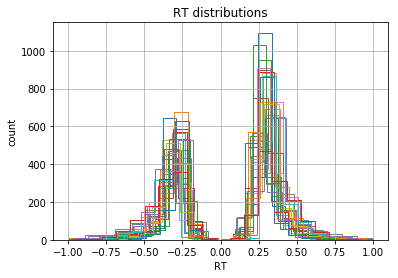

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in data.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

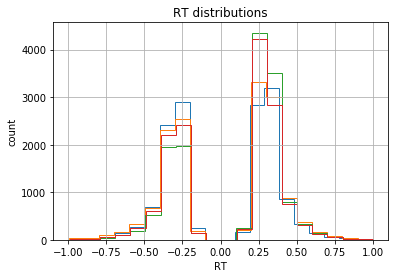

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in data.groupby('condition'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

In [11]:
np.unique(data.subj_idx), np.unique(data.condition), len(np.unique(data.subj_idx))

(array([761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773,
        774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784]),
 array(['hc', 'hv', 'lc', 'lv'], dtype=object),
 24)

In [12]:
np.sum(np.isnan(data.cpp))
np.sum(np.isnan(data.rt))
np.sum(np.isnan(data.response))

0

## Within-subjects regression 

#### Treatment specifies intercept (comparison condition) 
##### (here I'm estimating each predictor coefficient independently, without reference to a comparison condition)
#### C(x) specifies categorical predictor 

##### (design matrix will auto-code dummy variables)

#### trialwise response ~covariate:c(categorical predictor)

In [13]:
#learning signals
learning_signals =['cpp:C(condition)','B:C(condition)']
belief = learning_signals[1]
cpp = learning_signals[0]
#targets
targets  = [ 'v ~ ', 'a ~ ', 't ~ ']
v = targets[0]
a = targets[1]
tr = targets[2]

sample_cpp_formula = a+cpp 
sample_B_formula = v+belief 
n_samples, n_burned_samples = 3000, 500

In [14]:
sample_d_mat_cpp = dmatrix(cpp, data)
sample_d_mat_B = dmatrix(belief, data)

include=['v', 't', 'a', 'z']

print(sample_d_mat_cpp.design_info.column_names, sample_d_mat_B.design_info.column_names)

['Intercept', 'cpp:C(condition)[hc]', 'cpp:C(condition)[hv]', 'cpp:C(condition)[lc]', 'cpp:C(condition)[lv]'] ['Intercept', 'B:C(condition)[hc]', 'B:C(condition)[hv]', 'B:C(condition)[lc]', 'B:C(condition)[lv]']


In [15]:
sample_d_mat_cpp, sample_d_mat_B

(DesignMatrix with shape (57600, 5)
   Columns:
     ['Intercept',
      'cpp:C(condition)[hc]',
      'cpp:C(condition)[hv]',
      'cpp:C(condition)[lc]',
      'cpp:C(condition)[lv]']
   Terms:
     'Intercept' (column 0), 'cpp:C(condition)' (columns 1:5)
   (to view full data, use np.asarray(this_obj)),
 DesignMatrix with shape (57600, 5)
   Columns:
     ['Intercept',
      'B:C(condition)[hc]',
      'B:C(condition)[hv]',
      'B:C(condition)[lc]',
      'B:C(condition)[lv]']
   Terms:
     'Intercept' (column 0), 'B:C(condition)' (columns 1:5)
   (to view full data, use np.asarray(this_obj)))

In [16]:
data.columns

Index(['response', 'rt', 'condition', 'subj_idx', 'B', 'cpp'], dtype='object')

## Single-target models with a single learning signal 

### Is belief a learning signal for drift-rate, non-decision time, or decision threshold? 

In [17]:
#mapping belief, single learning signal, onto multiple targets
v_B_subj_obs_reg = hddm.HDDMRegressor(data,v+belief,bias=True, include=include, informative=True)
v_B_subj_obs_reg.sample(n_samples,burn=n_burned_samples,dbname='v_B_subj_obs_reg.db', db='pickle')

Adding these covariates:
['v_Intercept', 'v_B:C(condition)[hc]', 'v_B:C(condition)[hv]', 'v_B:C(condition)[lc]', 'v_B:C(condition)[lv]']


/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 3001 of 3000 complete in 7069.4 sec

/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/ana

In [18]:
a_B_subj_obs_reg = hddm.HDDMRegressor(data,a+belief,bias=True, include=include, informative=True)
a_B_subj_obs_reg.sample(n_samples,burn=n_burned_samples,dbname='a_B_subj_obs_reg.db', db='pickle')

Adding these covariates:
['a_Intercept', 'a_B:C(condition)[hc]', 'a_B:C(condition)[hv]', 'a_B:C(condition)[lc]', 'a_B:C(condition)[lv]']


/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 3001 of 3000 complete in 7200.5 sec

/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/ana

In [19]:
tr_B_subj_obs_reg = hddm.HDDMRegressor(data,tr+belief,bias=True, include=include, informative=True)
tr_B_subj_obs_reg.sample(n_samples,burn=n_burned_samples,dbname='tr_B_subj_obs_reg.db', db='pickle')

Adding these covariates:
['t_Intercept', 't_B:C(condition)[hc]', 't_B:C(condition)[hv]', 't_B:C(condition)[lc]', 't_B:C(condition)[lv]']


/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 3001 of 3000 complete in 8209.3 sec

/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/ana

### Is cpp a learning signal for drift-rate, non-decision time, or decision threshold? 

In [20]:
#mapping cpp, single learning signal, onto multiple targets
v_cpp_subj_obs_reg = hddm.HDDMRegressor(data,v+cpp,bias=True, include=include, informative=True)
v_cpp_subj_obs_reg.sample(n_samples,burn=n_burned_samples,dbname='v_cpp_subj_obs_reg.db', db='pickle')

Adding these covariates:
['v_Intercept', 'v_cpp:C(condition)[hc]', 'v_cpp:C(condition)[hv]', 'v_cpp:C(condition)[lc]', 'v_cpp:C(condition)[lv]']


/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 3001 of 3000 complete in 9901.5 sec

/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/ana

In [21]:
a_cpp_subj_obs_reg = hddm.HDDMRegressor(data,a+cpp,bias=True, include=include, informative=True)
a_cpp_subj_obs_reg.sample(n_samples,burn=n_burned_samples,dbname='a_cpp_subj_obs_reg.db', db='pickle')

Adding these covariates:
['a_Intercept', 'a_cpp:C(condition)[hc]', 'a_cpp:C(condition)[hv]', 'a_cpp:C(condition)[lc]', 'a_cpp:C(condition)[lv]']


/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 3001 of 3000 complete in 6598.9 sec

/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/ana

In [22]:
tr_cpp_subj_obs_reg = hddm.HDDMRegressor(data,tr+cpp,bias=True, include=include, informative=True)
tr_cpp_subj_obs_reg.sample(n_samples,burn=n_burned_samples,dbname='tr_cpp_subj_obs_reg.db', db='pickle')

Adding these covariates:
['t_Intercept', 't_cpp:C(condition)[hc]', 't_cpp:C(condition)[hv]', 't_cpp:C(condition)[lc]', 't_cpp:C(condition)[lv]']


/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 3001 of 3000 complete in 8258.1 sec

/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/ana

### assess convergence

Plotting a
Plotting a_std
Plotting t
Plotting t_std
Plotting z
Plotting z_std
Plotting v_Intercept
Plotting v_Intercept_std
Plotting v_cpp:C(condition)[hc]
Plotting v_cpp:C(condition)[hv]
Plotting v_cpp:C(condition)[lc]
Plotting v_cpp:C(condition)[lv]


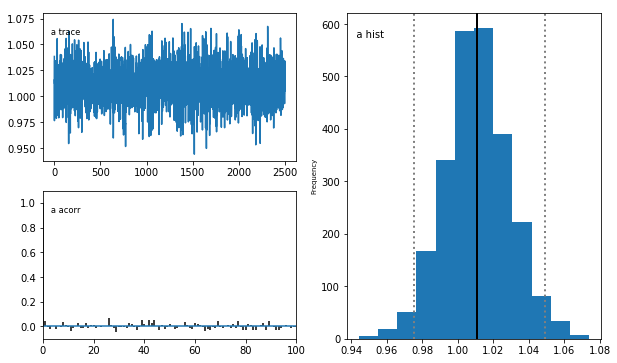

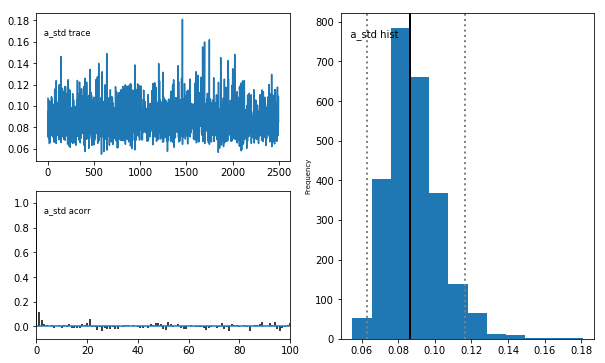

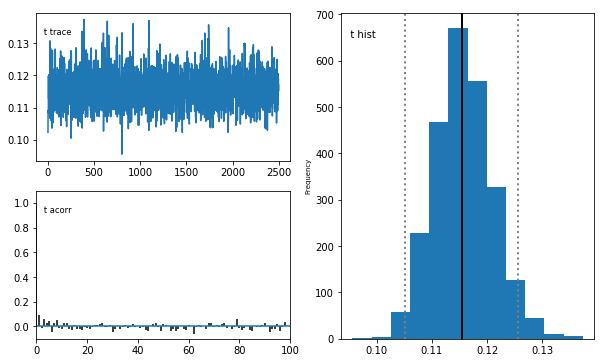

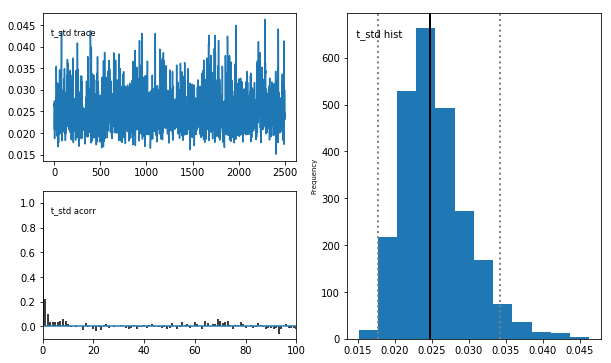

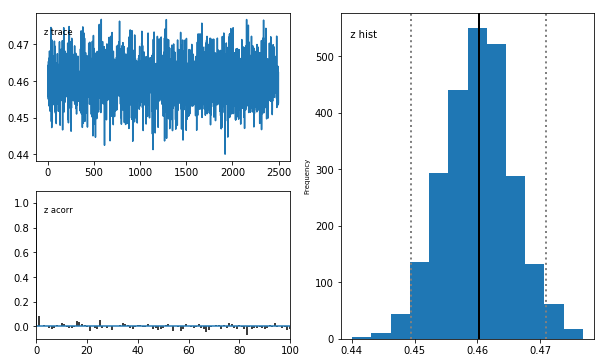

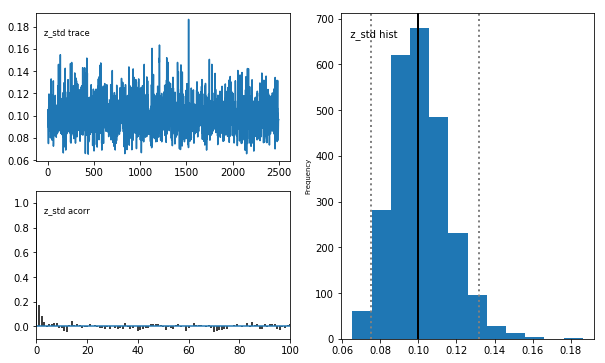

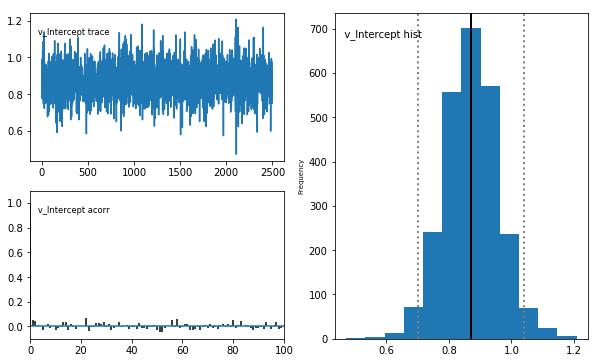

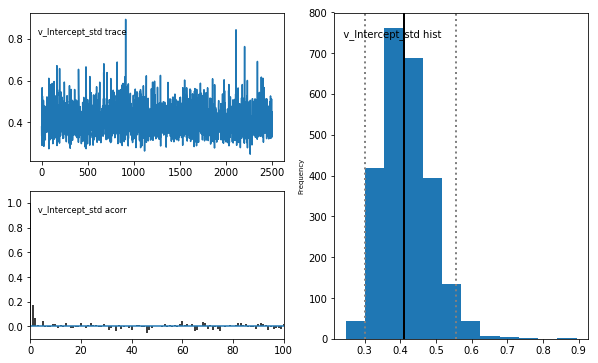

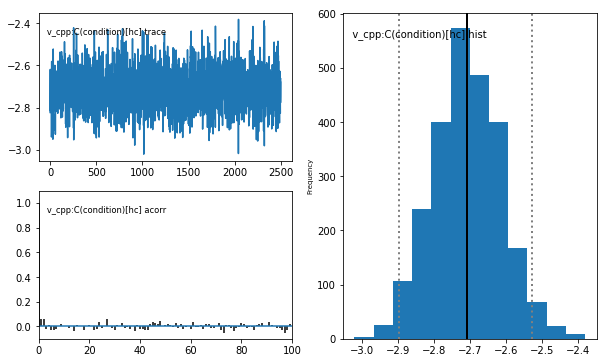

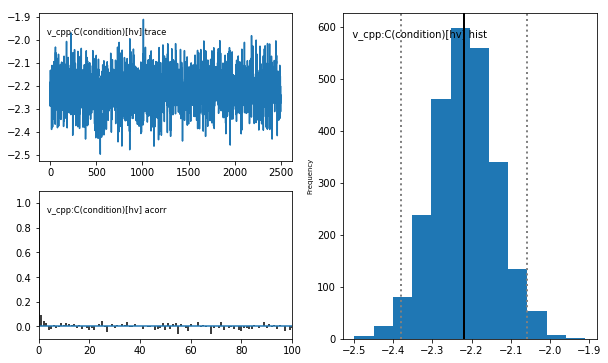

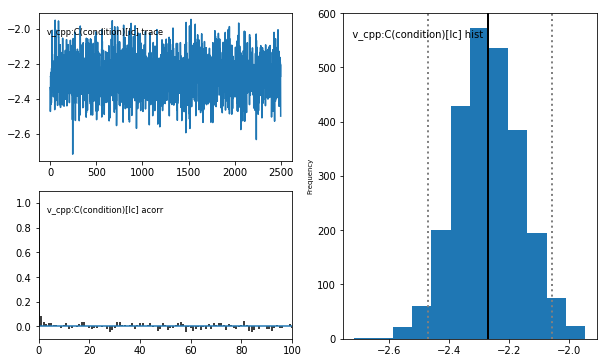

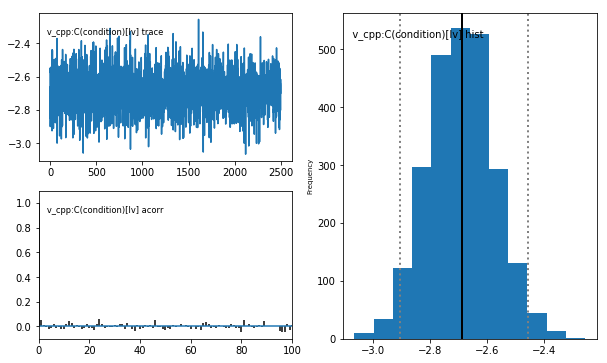

In [23]:
v_cpp_subj_obs_reg.plot_posteriors()

Plotting v
Plotting v_std
Plotting t
Plotting t_std
Plotting z
Plotting z_std
Plotting a_Intercept
Plotting a_Intercept_std
Plotting a_cpp:C(condition)[hc]
Plotting a_cpp:C(condition)[hv]
Plotting a_cpp:C(condition)[lc]
Plotting a_cpp:C(condition)[lv]


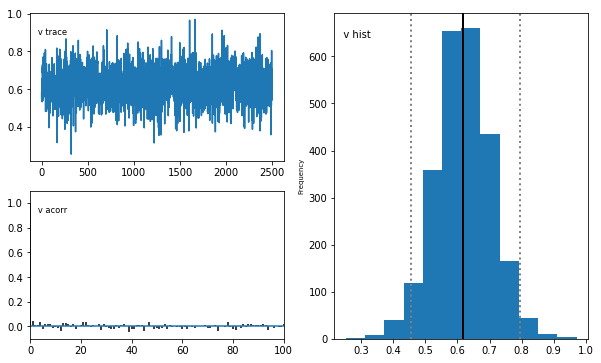

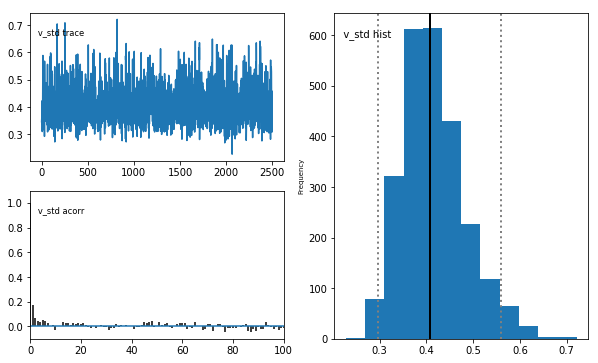

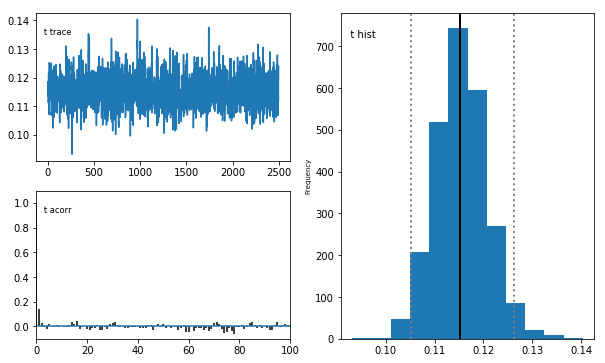

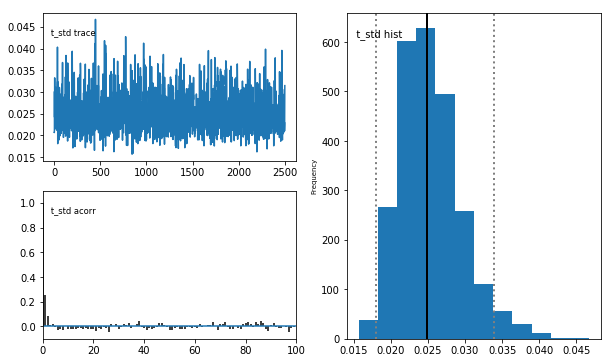

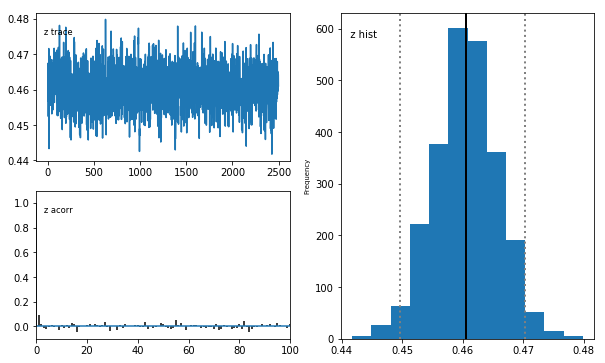

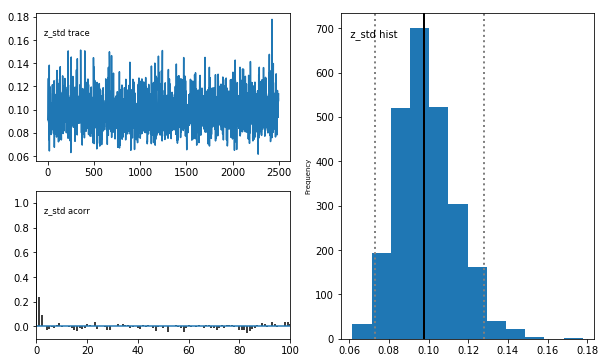

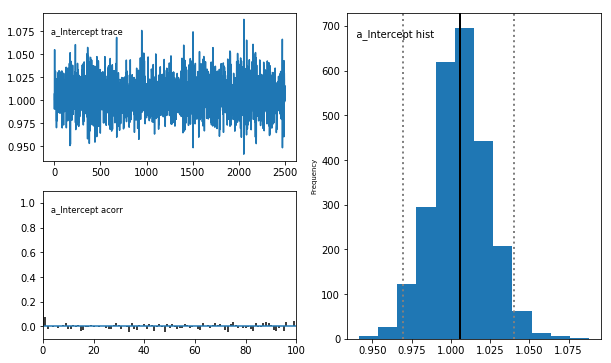

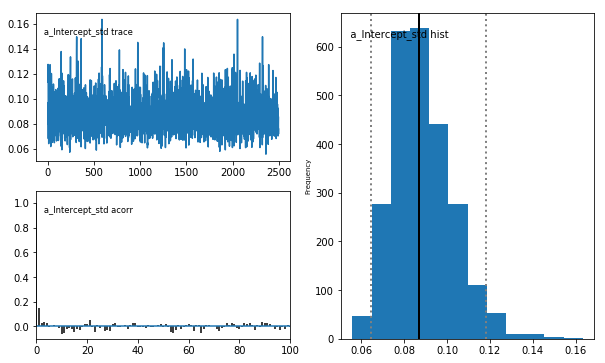

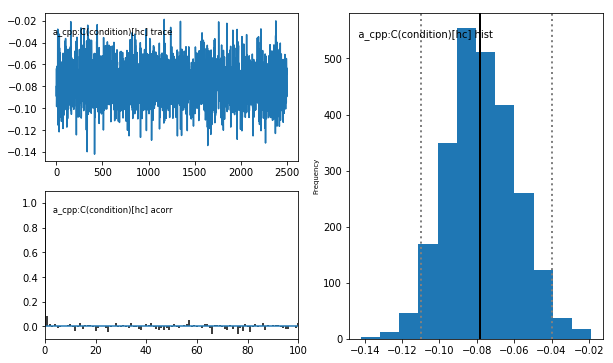

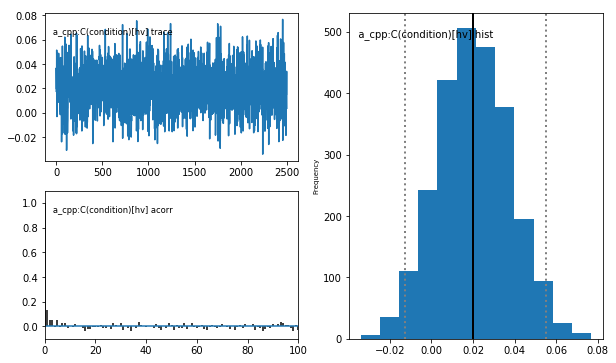

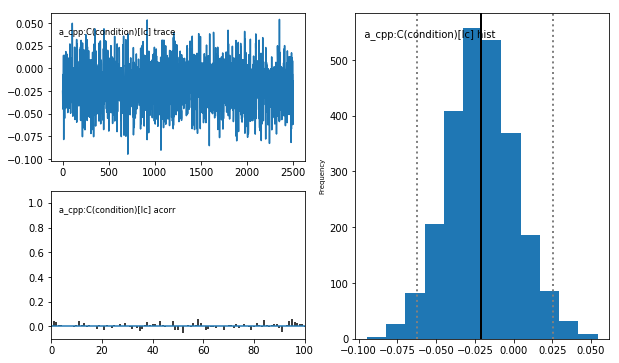

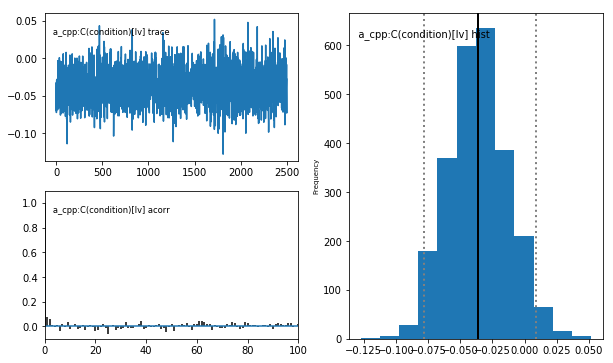

In [24]:
a_cpp_subj_obs_reg.plot_posteriors()

Plotting a
Plotting a_std
Plotting v
Plotting v_std
Plotting z
Plotting z_std
Plotting t_Intercept
Plotting t_Intercept_std
Plotting t_cpp:C(condition)[hc]
Plotting t_cpp:C(condition)[hv]
Plotting t_cpp:C(condition)[lc]
Plotting t_cpp:C(condition)[lv]


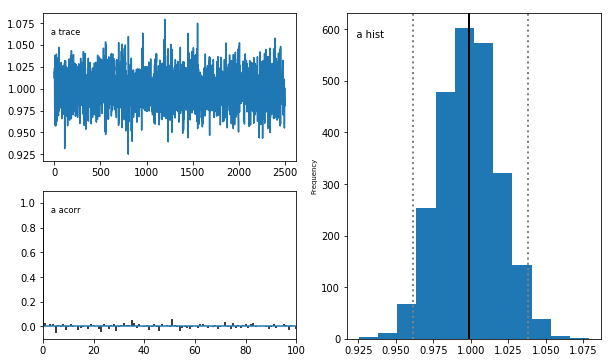

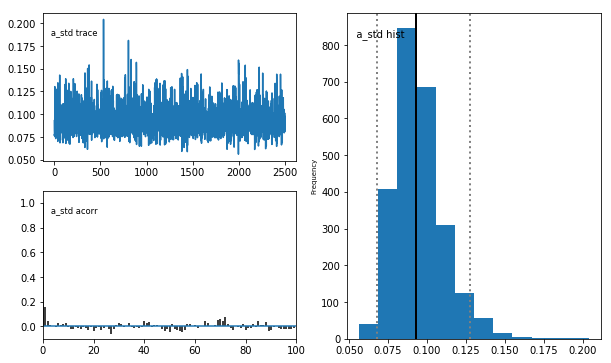

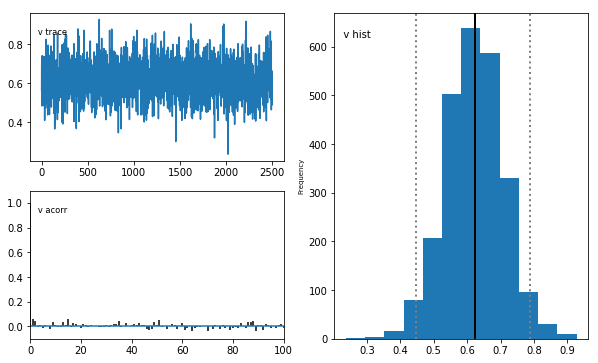

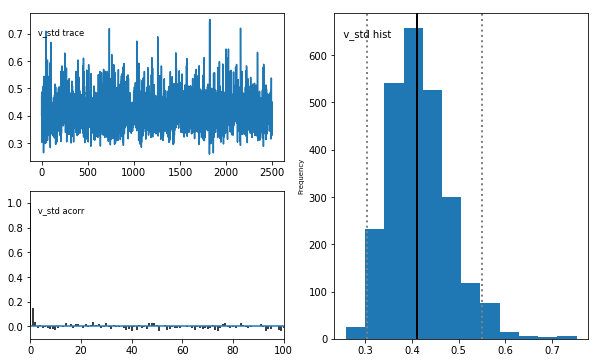

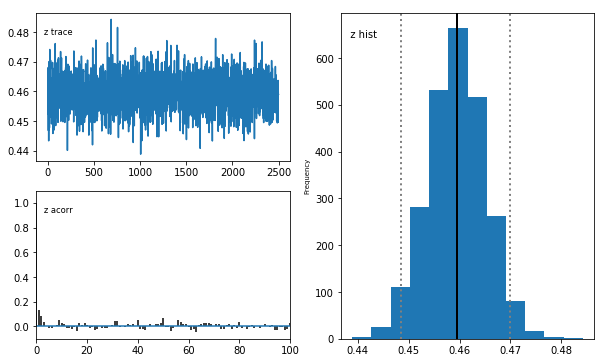

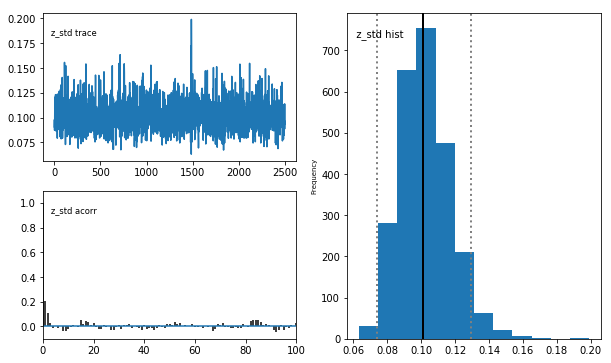

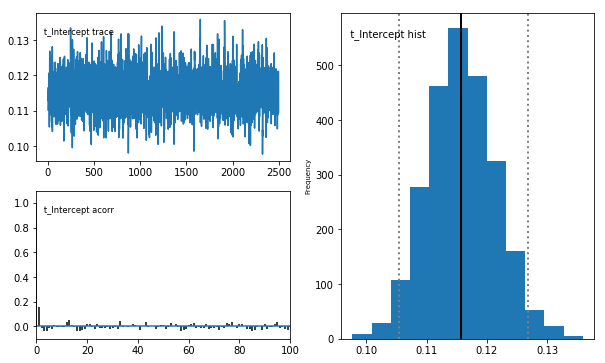

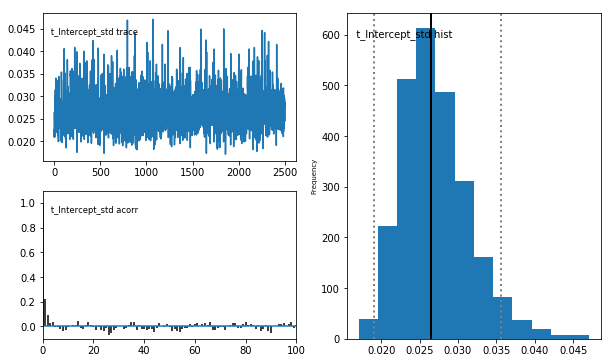

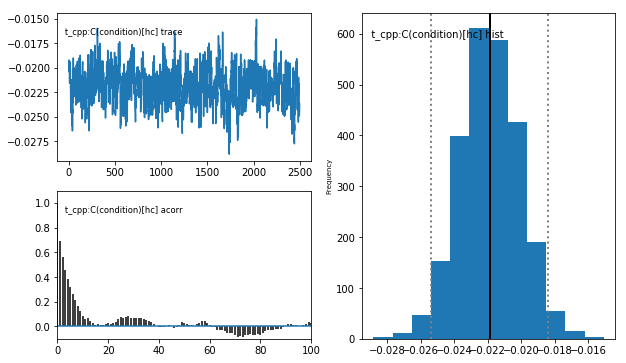

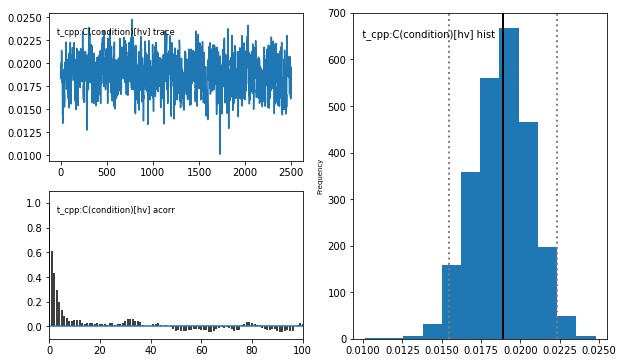

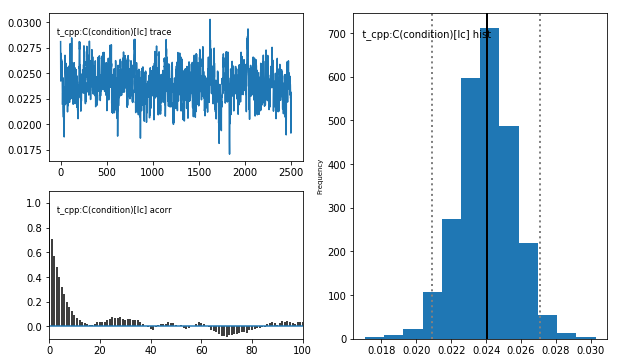

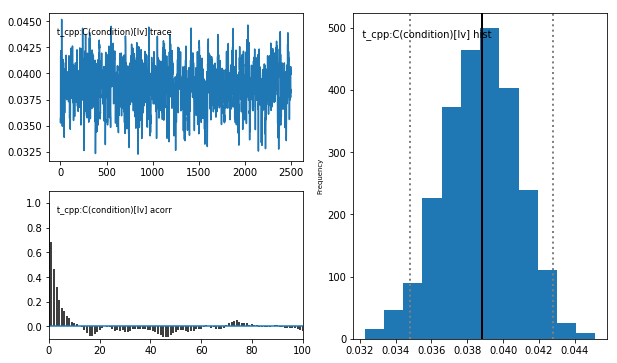

In [25]:
tr_cpp_subj_obs_reg.plot_posteriors()

Plotting a
Plotting a_std
Plotting t
Plotting t_std
Plotting z
Plotting z_std
Plotting v_Intercept
Plotting v_Intercept_std
Plotting v_B:C(condition)[hc]
Plotting v_B:C(condition)[hv]
Plotting v_B:C(condition)[lc]
Plotting v_B:C(condition)[lv]


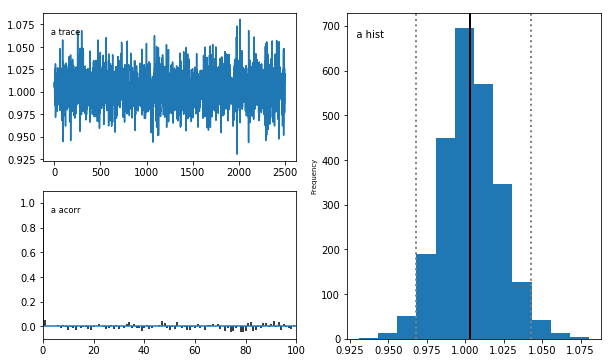

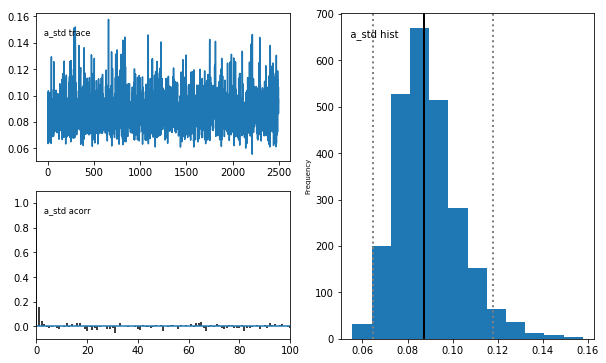

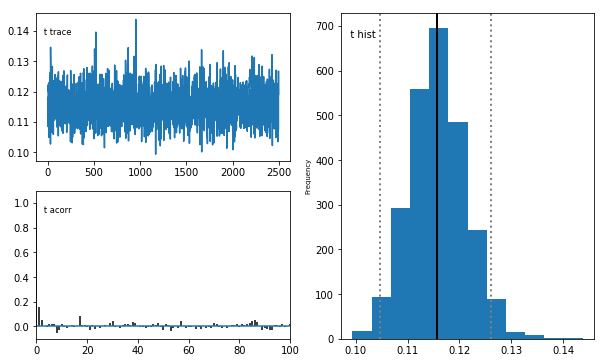

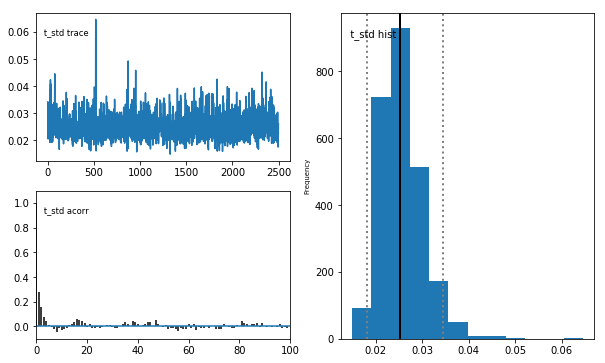

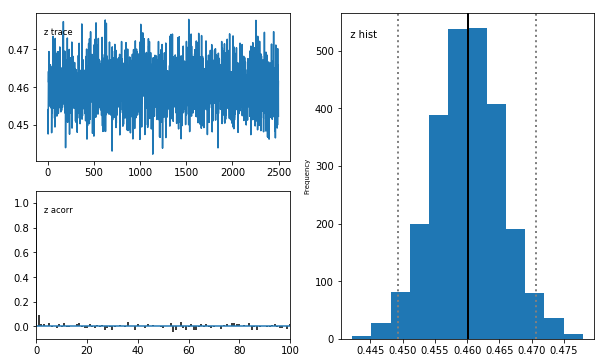

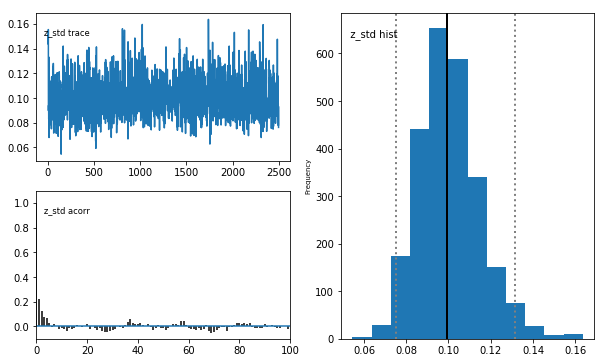

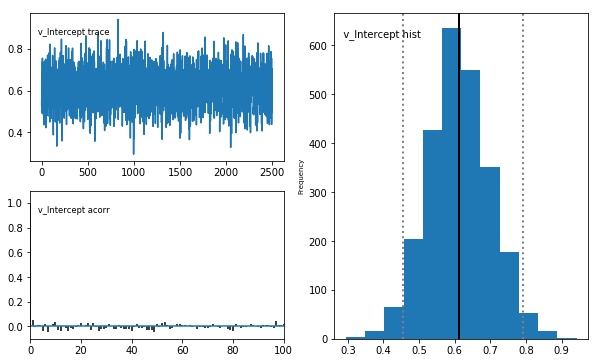

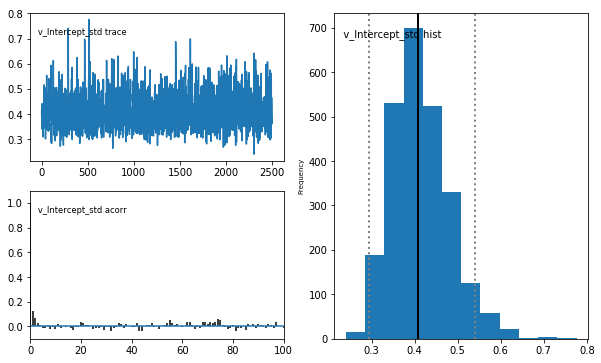

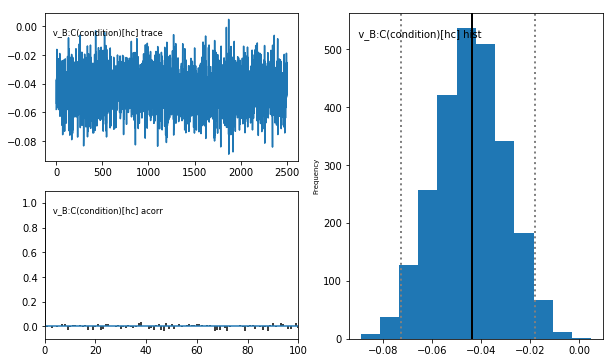

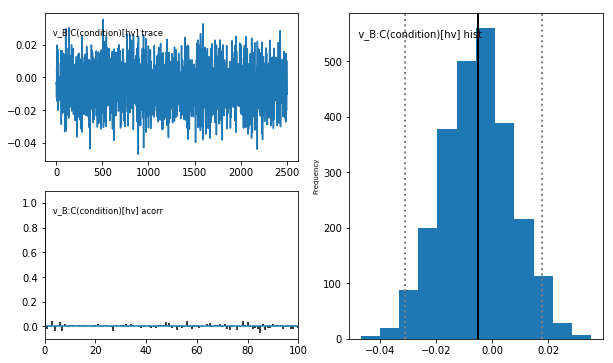

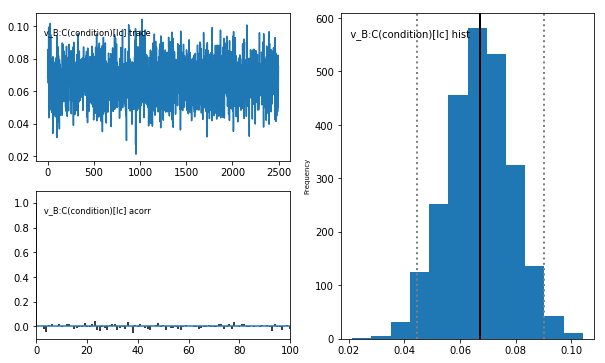

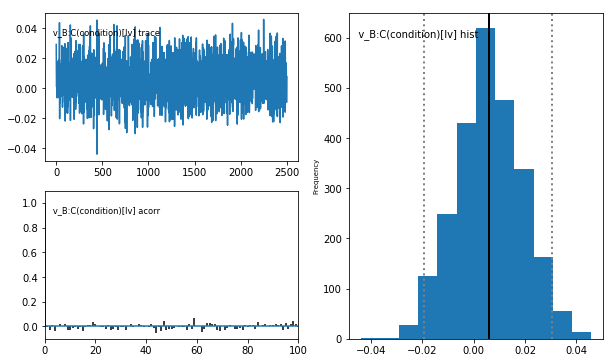

In [26]:
v_B_subj_obs_reg.plot_posteriors()

Plotting v
Plotting v_std
Plotting t
Plotting t_std
Plotting z
Plotting z_std
Plotting a_Intercept
Plotting a_Intercept_std
Plotting a_B:C(condition)[hc]
Plotting a_B:C(condition)[hv]
Plotting a_B:C(condition)[lc]
Plotting a_B:C(condition)[lv]


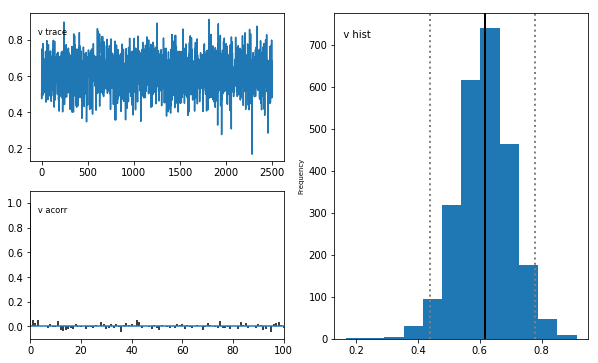

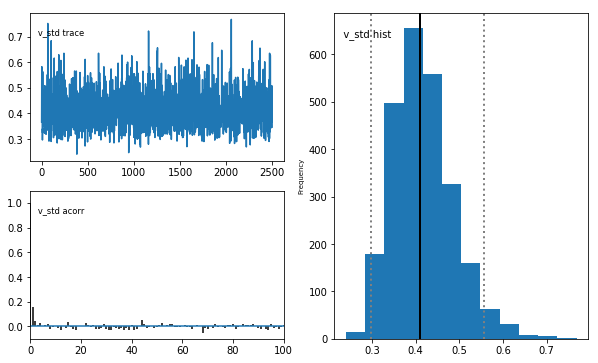

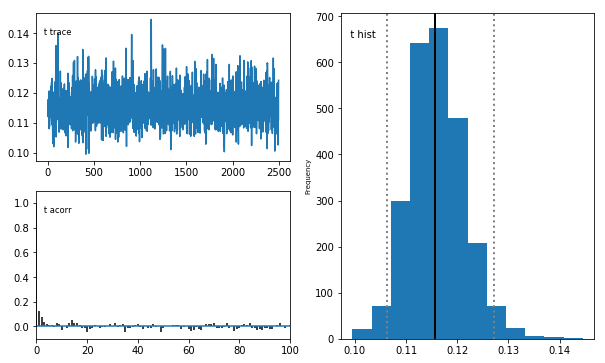

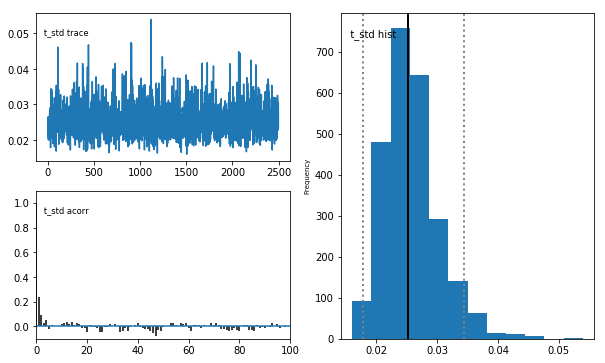

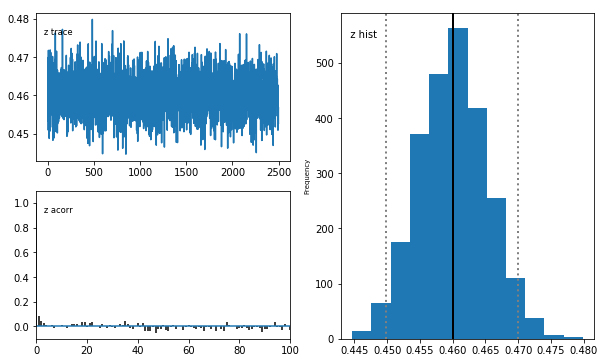

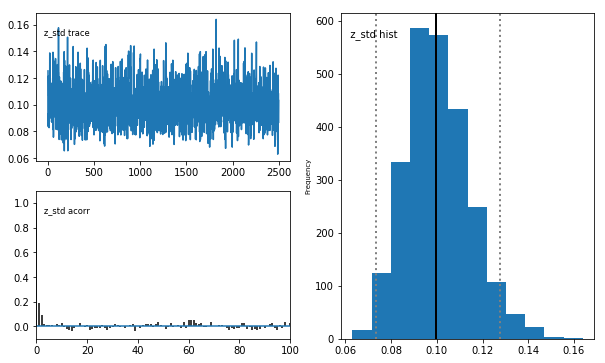

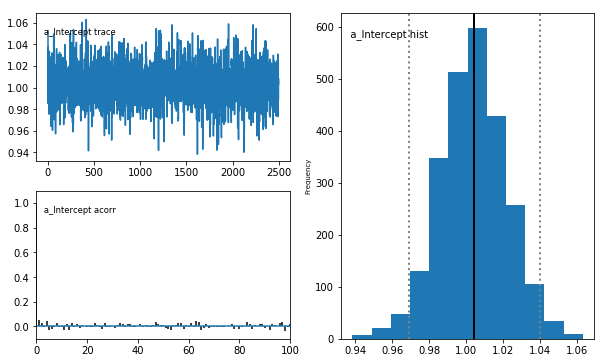

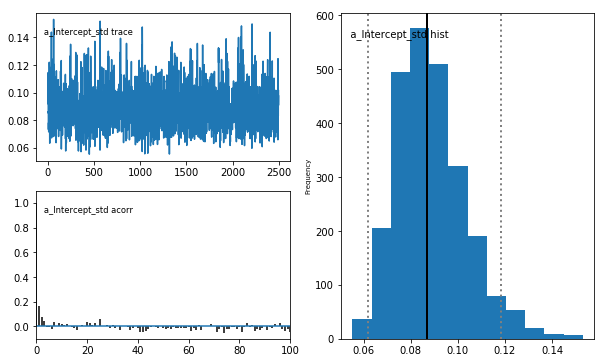

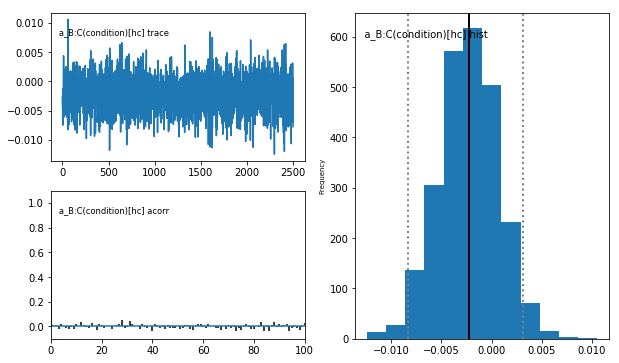

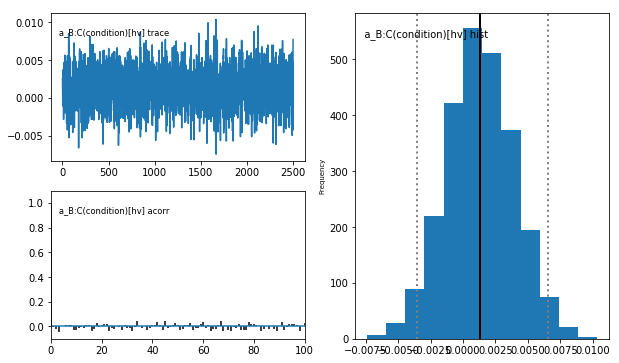

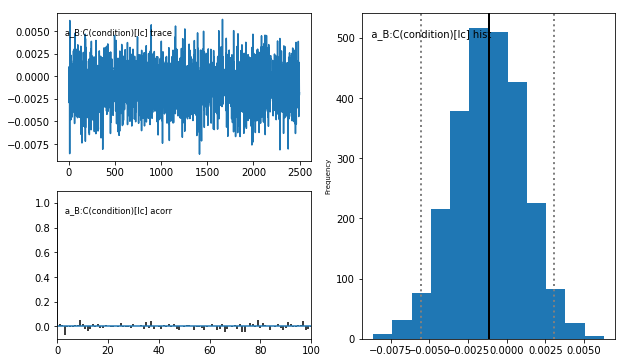

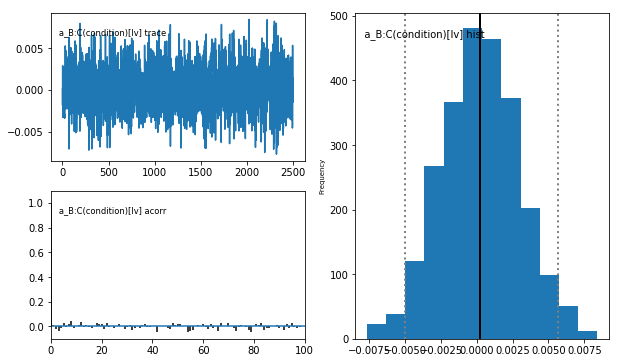

In [27]:
a_B_subj_obs_reg.plot_posteriors()

Plotting a
Plotting a_std
Plotting v
Plotting v_std
Plotting z
Plotting z_std
Plotting t_Intercept
Plotting t_Intercept_std
Plotting t_B:C(condition)[hc]
Plotting t_B:C(condition)[hv]
Plotting t_B:C(condition)[lc]
Plotting t_B:C(condition)[lv]


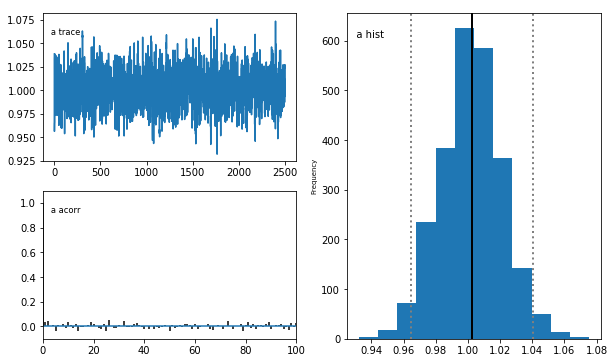

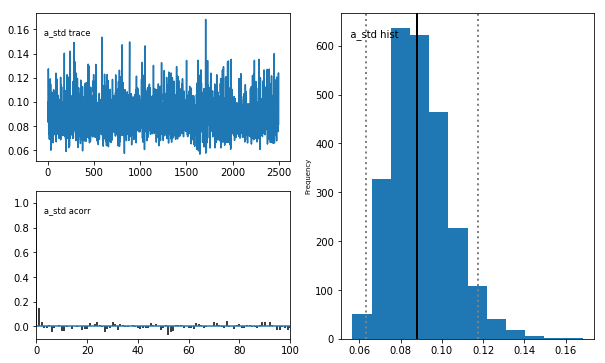

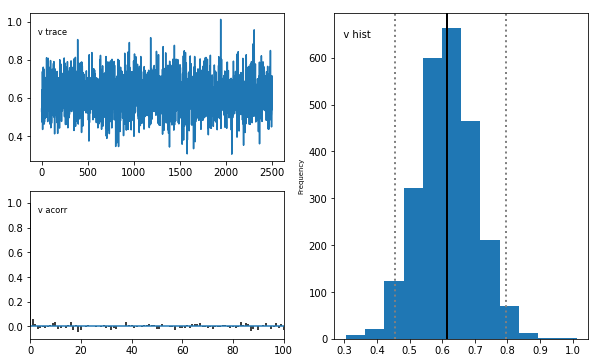

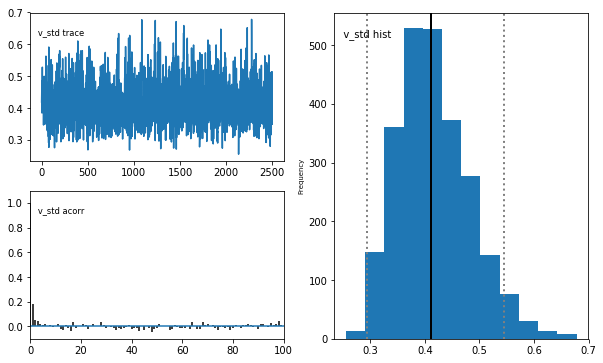

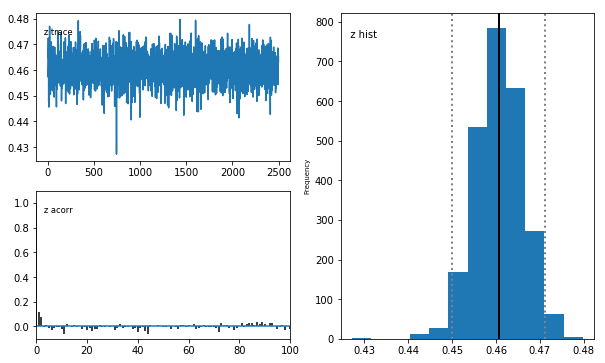

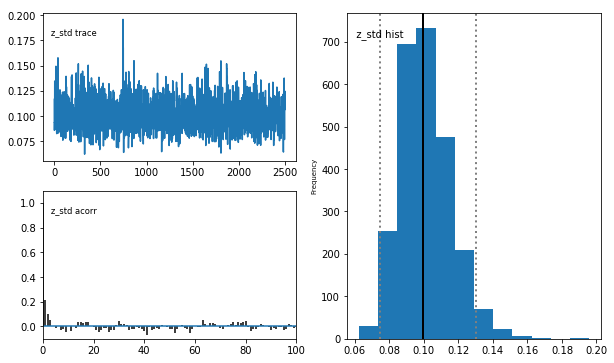

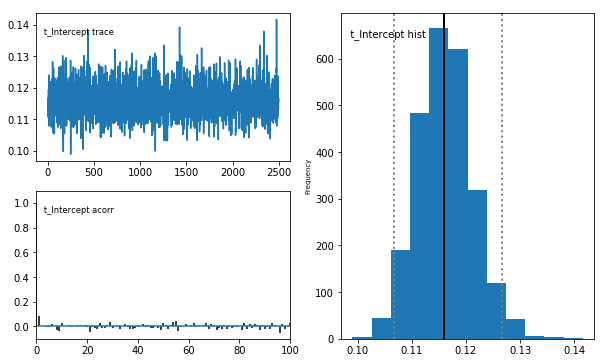

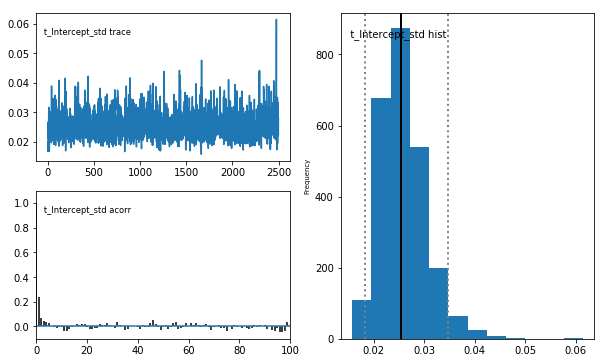

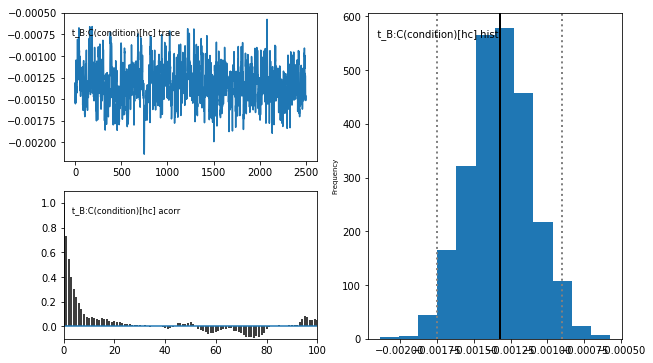

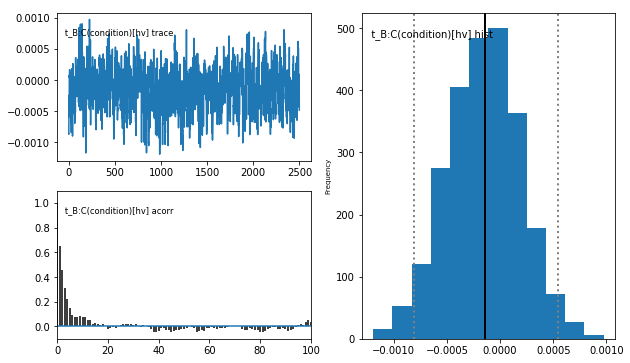

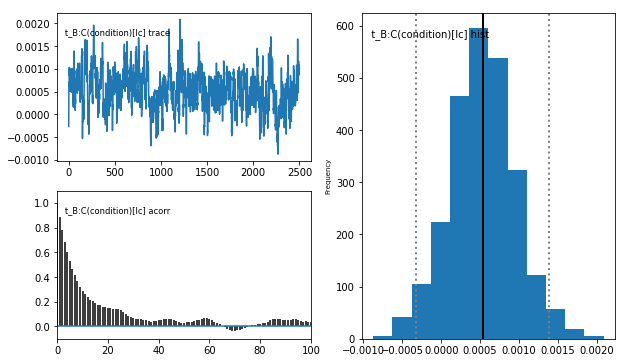

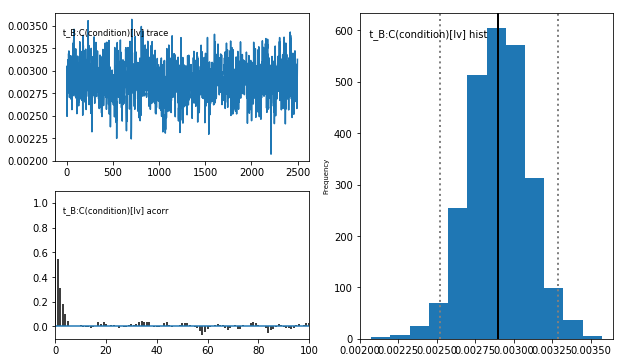

In [28]:
tr_B_subj_obs_reg.plot_posteriors()

(-12600, -10000)

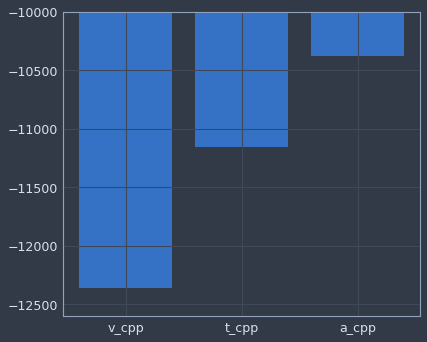

In [29]:
#compare dics    
from jupyterthemes import jtplot
jtplot.style()
cpp_m_names = ['v_cpp', 't_cpp', 'a_cpp']
cpp_dics = [v_cpp_subj_obs_reg.dic,tr_cpp_subj_obs_reg.dic,a_cpp_subj_obs_reg.dic]
plt.bar(cpp_m_names,cpp_dics)
plt.ylim([-12600,-10000])

(-10600, -10000)

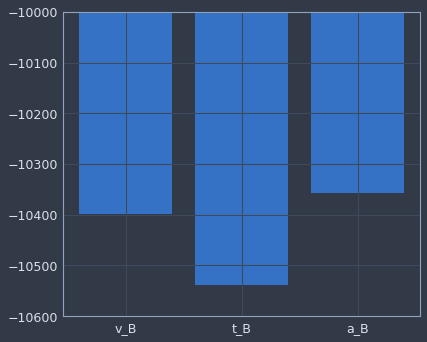

In [30]:
B_m_names = ['v_B', 't_B', 'a_B']
B_dics = [v_B_subj_obs_reg.dic,tr_B_subj_obs_reg.dic,a_B_subj_obs_reg.dic]
plt.bar(B_m_names,B_dics)
plt.ylim([-10600,-10000])

In [85]:
#save the models 
v_cpp_subj_obs_reg.save(write_dir+'v_cpp_subj_obs_reg')
tr_cpp_subj_obs_reg.save(write_dir+'tr_cpp_subj_obs_reg')
a_cpp_subj_obs_reg.save(write_dir+'a_cpp_subj_obs_reg')

In [86]:
v_B_subj_obs_reg.save(write_dir+'v_B_subj_obs_reg')
tr_B_subj_obs_reg.save(write_dir+'tr_B_subj_obs_reg')
a_B_subj_obs_reg.save(write_dir+'a_B_subj_obs_reg')

In [31]:
all_dics=cpp_dics+B_dics
all_m_names = cpp_m_names+B_m_names
single_param_single_ls_dict = dict(zip(all_m_names, all_dics))
single_param_single_ls_df = pd.DataFrame(single_param_single_ls_dict,index=[0])

In [32]:
single_param_single_ls_df

a_B         a_cpp           t_B         t_cpp           v_B  \
0 -10356.858052 -10377.332988 -10538.040341 -11155.222288 -10398.942274   

          v_cpp  
0 -12355.666097

(-12500, -10000)

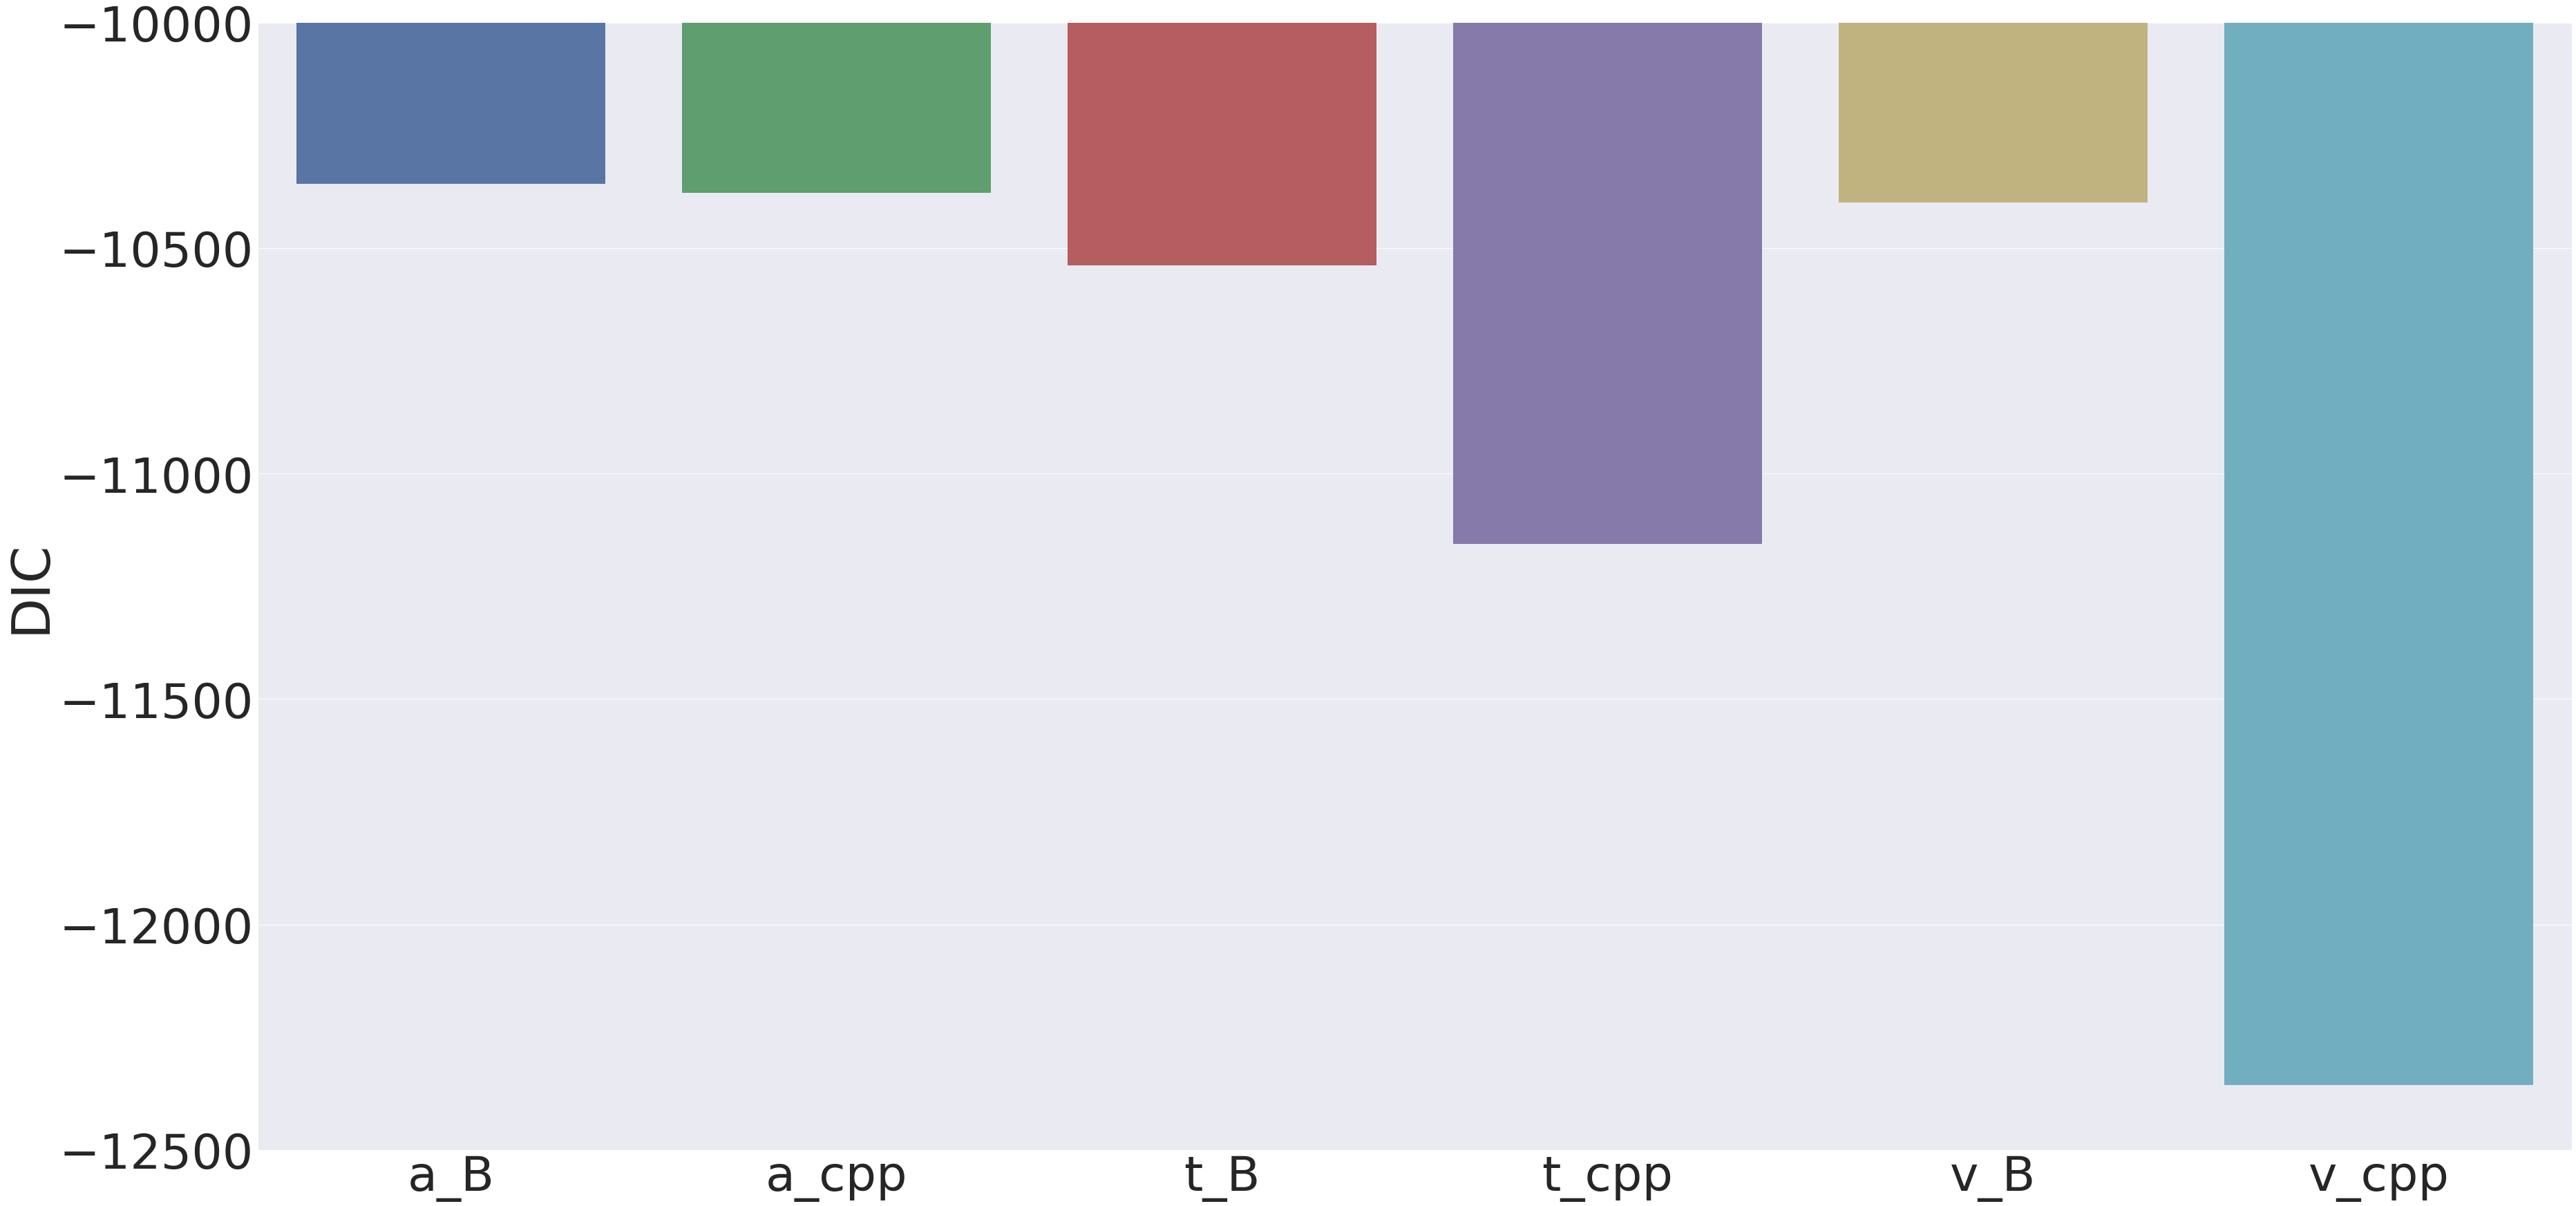

In [33]:
sns.set(font_scale=7)  
plt.figure(figsize=(60,30))
ax=sns.barplot(data=single_param_single_ls_df)
ax.set(ylabel='DIC')
plt.ylim([-12500,-10000])

## Single target models with two learning signals 

In [34]:
cpp_belief='cpp:C(condition)+B:C(condition)'

In [35]:
#mapping multiple learning signals onto a single target
v_cpp_B_subj_obs_reg = hddm.HDDMRegressor(data,v+cpp_belief,bias=True, include=include, informative=True)
v_cpp_B_subj_obs_reg.sample(n_samples,burn=n_burned_samples,dbname='v_cpp_B_subj_obs_reg.db', db='pickle')

Adding these covariates:
['v_Intercept', 'v_cpp:C(condition)[hc]', 'v_cpp:C(condition)[hv]', 'v_cpp:C(condition)[lc]', 'v_cpp:C(condition)[lv]', 'v_B:C(condition)[hc]', 'v_B:C(condition)[hv]', 'v_B:C(condition)[lc]', 'v_B:C(condition)[lv]']


/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 3001 of 3000 complete in 13164.4 sec

/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/ana

In [36]:
a_cpp_B_subj_obs_reg = hddm.HDDMRegressor(data,a+cpp_belief,bias=True, include=include, informative=True)
a_cpp_B_subj_obs_reg.sample(n_samples,burn=n_burned_samples,dbname='a_cpp_B_subj_obs_reg.db', db='pickle')

Adding these covariates:
['a_Intercept', 'a_cpp:C(condition)[hc]', 'a_cpp:C(condition)[hv]', 'a_cpp:C(condition)[lc]', 'a_cpp:C(condition)[lv]', 'a_B:C(condition)[hc]', 'a_B:C(condition)[hv]', 'a_B:C(condition)[lc]', 'a_B:C(condition)[lv]']


/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 3001 of 3000 complete in 10408.4 sec

/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/ana

In [37]:
tr_cpp_B_subj_obs_reg = hddm.HDDMRegressor(data,tr+cpp_belief,bias=True, include=include, informative=True)
tr_cpp_B_subj_obs_reg.sample(n_samples,burn=n_burned_samples,dbname='tr_cpp_B_subj_obs_reg.db', db='pickle')

Adding these covariates:
['t_Intercept', 't_cpp:C(condition)[hc]', 't_cpp:C(condition)[hv]', 't_cpp:C(condition)[lc]', 't_cpp:C(condition)[lv]', 't_B:C(condition)[hc]', 't_B:C(condition)[hv]', 't_B:C(condition)[lc]', 't_B:C(condition)[lv]']


/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 3001 of 3000 complete in 11976.2 sec

/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/ana

(-12600, -10000)

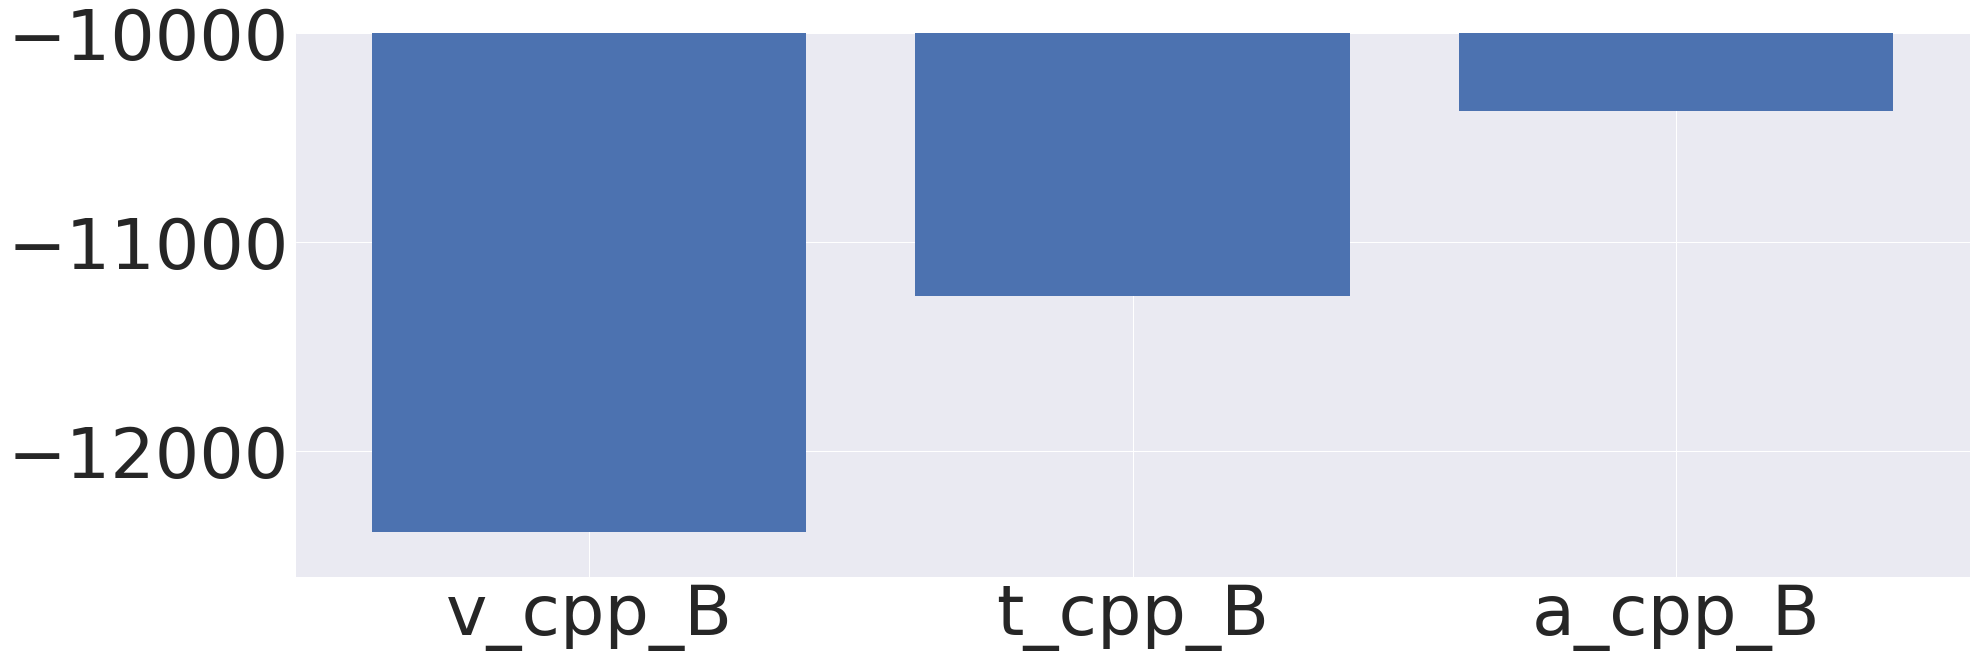

In [51]:
#compare dics    
plt.rcParams['figure.figsize'] = 30, 10
cpp_m_names = ['v_cpp_B', 't_cpp_B', 'a_cpp_B']
cpp_dics = [v_cpp_B_subj_obs_reg.dic,tr_cpp_B_subj_obs_reg.dic,a_cpp_B_subj_obs_reg.dic]
plt.bar(cpp_m_names,cpp_dics)
plt.ylim([-12600,-10000])

In [87]:
v_cpp_B_subj_obs_reg.save(write_dir+'v_cpp_B_subj_obs_reg')
tr_cpp_B_subj_obs_reg.save(write_dir+'tr_cpp_B_subj_obs_reg')
a_cpp_B_subj_obs_reg.save(write_dir+'a_cpp_B_subj_obs_reg')

   ## Single learning signal, two targets

In [39]:
#v combinations 
#v_B & a_B - 
#v_B & t_B -
#v_cpp & a_cpp -
#v_cpp & t_cpp -

#a combinations 
#a_B & t_B -
#a_cpp & t_cpp -

In [40]:
[v+belief, a+belief]

['v ~ B:C(condition)', 'a ~ B:C(condition)']

In [41]:
v_a_B_subj_obs_reg = hddm.HDDMRegressor(data,[v+belief, a+belief],bias=True, include=include, informative=True)
v_a_B_subj_obs_reg.sample(n_samples,burn=n_burned_samples,dbname='v_a_B_subj_obs_reg.db', db='pickle')

Adding these covariates:
['v_Intercept', 'v_B:C(condition)[hc]', 'v_B:C(condition)[hv]', 'v_B:C(condition)[lc]', 'v_B:C(condition)[lv]']
Adding these covariates:
['a_Intercept', 'a_B:C(condition)[hc]', 'a_B:C(condition)[hv]', 'a_B:C(condition)[lc]', 'a_B:C(condition)[lv]']


/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 3001 of 3000 complete in 15012.6 sec

/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/ana

In [42]:
v_t_B_subj_obs_reg = hddm.HDDMRegressor(data,[v+belief, tr+belief],bias=True, include=include, informative=True)
v_t_B_subj_obs_reg.sample(n_samples,burn=n_burned_samples,dbname='v_tr_B_subj_obs_reg.db', db='pickle')

Adding these covariates:
['v_Intercept', 'v_B:C(condition)[hc]', 'v_B:C(condition)[hv]', 'v_B:C(condition)[lc]', 'v_B:C(condition)[lv]']
Adding these covariates:
['t_Intercept', 't_B:C(condition)[hc]', 't_B:C(condition)[hv]', 't_B:C(condition)[lc]', 't_B:C(condition)[lv]']


/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 3001 of 3000 complete in 16390.1 sec

/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/ana

In [43]:
v_a_cpp_subj_obs_reg = hddm.HDDMRegressor(data,[v+cpp, a+cpp],bias=True, include=include, informative=True)
v_a_cpp_subj_obs_reg.sample(n_samples,burn=n_burned_samples,dbname='v_a_cpp_subj_obs_reg.db', db='pickle')

Adding these covariates:
['v_Intercept', 'v_cpp:C(condition)[hc]', 'v_cpp:C(condition)[hv]', 'v_cpp:C(condition)[lc]', 'v_cpp:C(condition)[lv]']
Adding these covariates:
['a_Intercept', 'a_cpp:C(condition)[hc]', 'a_cpp:C(condition)[hv]', 'a_cpp:C(condition)[lc]', 'a_cpp:C(condition)[lv]']


/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 3001 of 3000 complete in 18294.2 sec

/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/ana

In [44]:
v_t_cpp_subj_obs_reg = hddm.HDDMRegressor(data,[v+cpp, tr+cpp],bias=True, include=include, informative=True)
v_t_cpp_subj_obs_reg.sample(n_samples,burn=n_burned_samples,dbname='v_tr_cpp_subj_obs_reg.db', db='pickle')

Adding these covariates:
['v_Intercept', 'v_cpp:C(condition)[hc]', 'v_cpp:C(condition)[hv]', 'v_cpp:C(condition)[lc]', 'v_cpp:C(condition)[lv]']
Adding these covariates:
['t_Intercept', 't_cpp:C(condition)[hc]', 't_cpp:C(condition)[hv]', 't_cpp:C(condition)[lc]', 't_cpp:C(condition)[lv]']


/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 3001 of 3000 complete in 20877.8 sec

/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/ana

In [45]:
a_t_B_subj_obs_reg = hddm.HDDMRegressor(data,[a+belief, tr+belief],bias=True, include=include, informative=True)
a_t_B_subj_obs_reg.sample(n_samples,burn=n_burned_samples,dbname='a_tr_B_subj_obs_reg.db', db='pickle')

Adding these covariates:
['a_Intercept', 'a_B:C(condition)[hc]', 'a_B:C(condition)[hv]', 'a_B:C(condition)[lc]', 'a_B:C(condition)[lv]']
Adding these covariates:
['t_Intercept', 't_B:C(condition)[hc]', 't_B:C(condition)[hv]', 't_B:C(condition)[lc]', 't_B:C(condition)[lv]']


/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 3001 of 3000 complete in 16008.7 sec

/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/ana

In [46]:
a_t_cpp_subj_obs_reg = hddm.HDDMRegressor(data,[a+cpp, tr+cpp],bias=True, include=include, informative=True)
a_t_cpp_subj_obs_reg.sample(n_samples,burn=n_burned_samples,dbname='a_tr_cpp_subj_obs_reg.db', db='pickle')

Adding these covariates:
['a_Intercept', 'a_cpp:C(condition)[hc]', 'a_cpp:C(condition)[hv]', 'a_cpp:C(condition)[lc]', 'a_cpp:C(condition)[lv]']
Adding these covariates:
['t_Intercept', 't_cpp:C(condition)[hc]', 't_cpp:C(condition)[hv]', 't_cpp:C(condition)[lc]', 't_cpp:C(condition)[lv]']


/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 3001 of 3000 complete in 16011.6 sec

/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/ana

In [88]:
v_a_B_subj_obs_reg.save(write_dir+'v_a_B_subj_obs_reg')
v_t_B_subj_obs_reg.save(write_dir+'v_t_B_subj_obs_reg')
v_a_cpp_subj_obs_reg.save(write_dir+'v_a_cpp_subj_obs_reg')

v_t_cpp_subj_obs_reg.save(write_dir+'v_t_cpp_subj_obs_reg')
a_t_B_subj_obs_reg.save(write_dir+'a_t_B_subj_obs_reg')
a_t_cpp_subj_obs_reg.save(write_dir+'a_t_cpp_subj_obs_reg')

Text(0.5,1,'single learning signal & two targets')

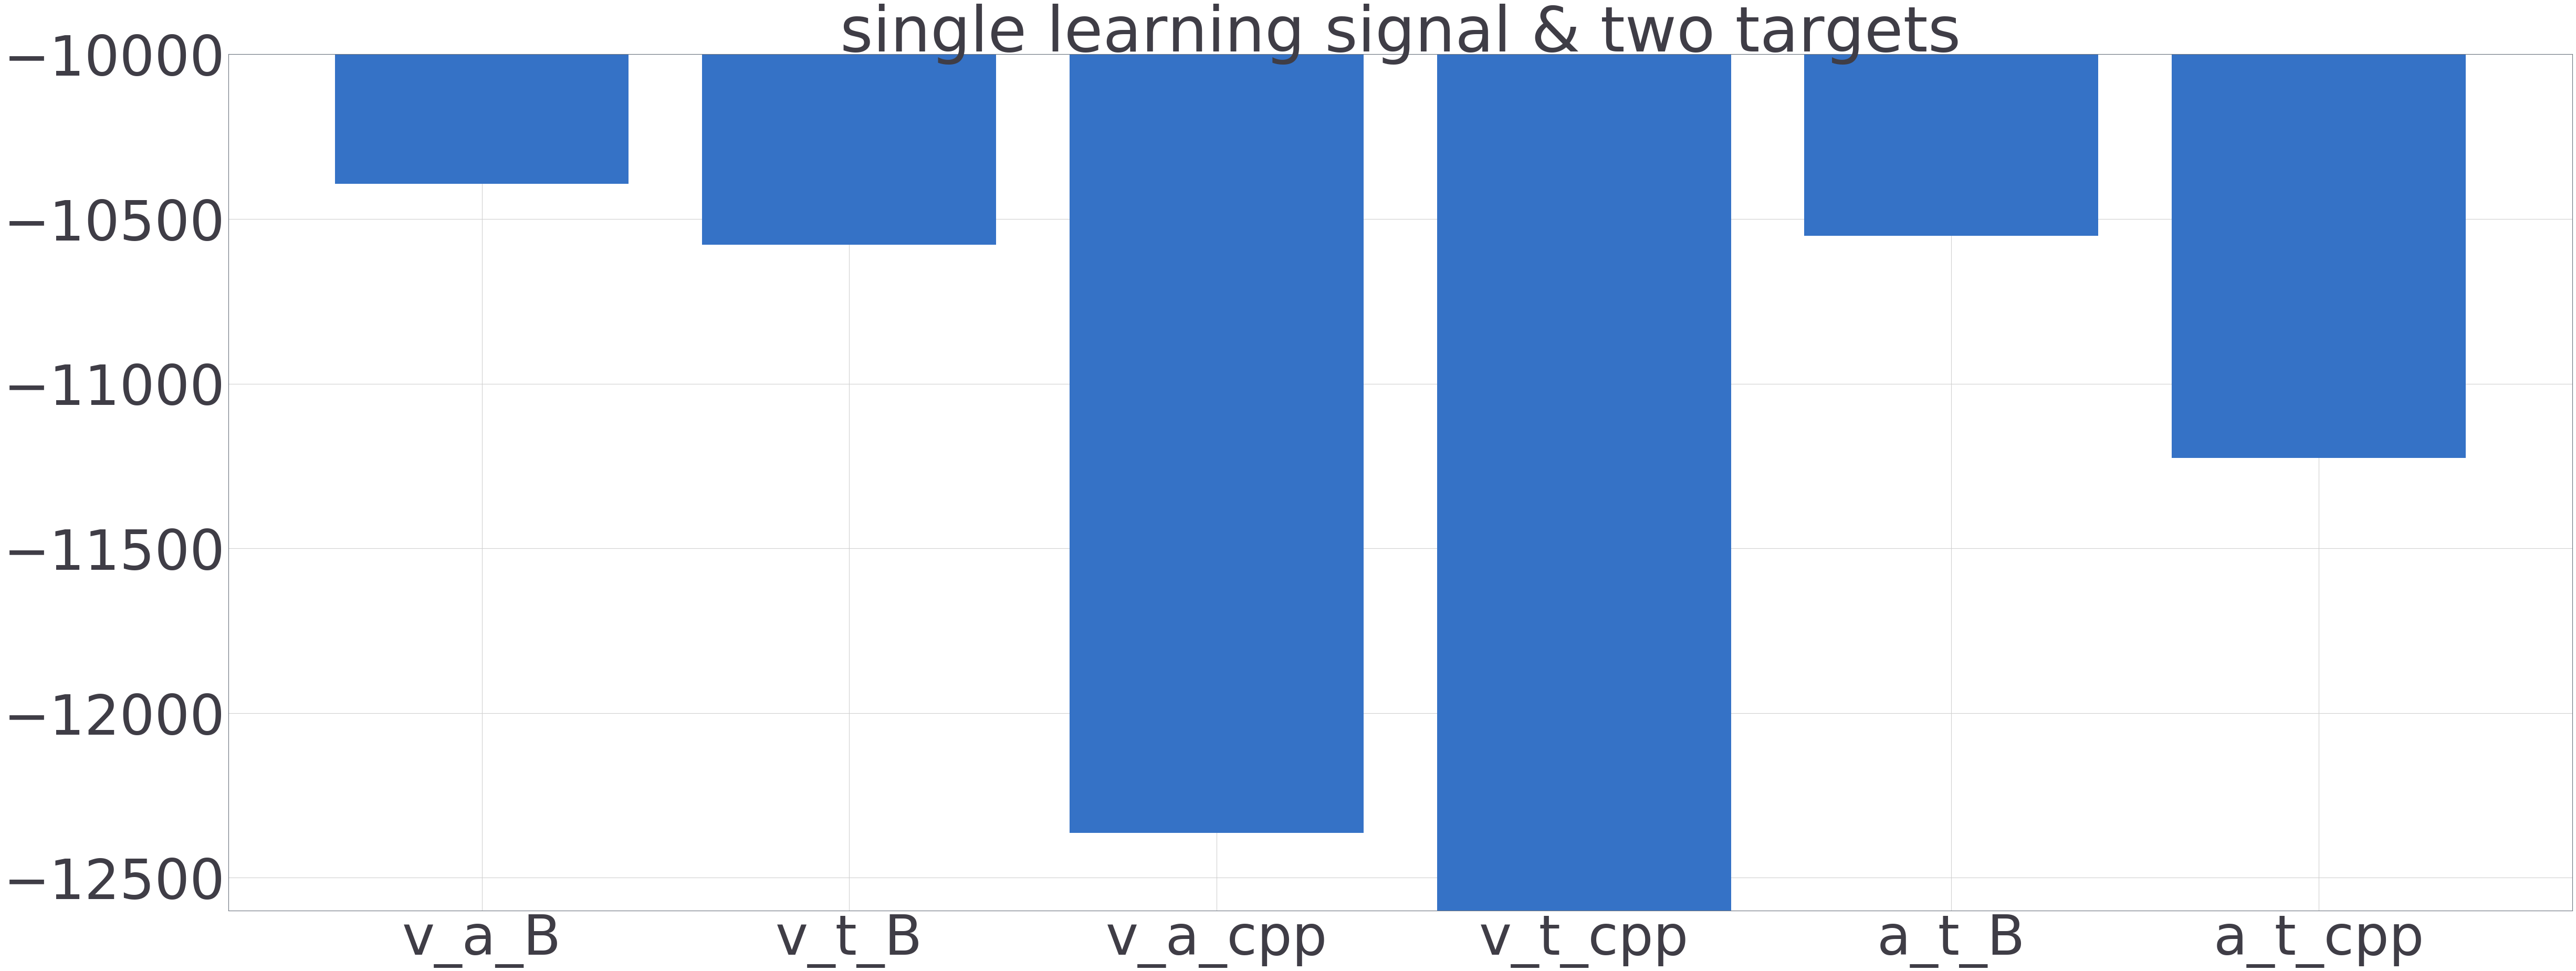

In [60]:
#compare dics 
jtplot.style('grade3', context='paper', fscale=10)
plt.rcParams['figure.figsize'] = 80, 30
ls_1_t_2_m_names = ['v_a_B', 'v_t_B', 'v_a_cpp',
              'v_t_cpp', 'a_t_B', 'a_t_cpp']
ls_1_t_2_m_dics = [v_a_B_subj_obs_reg.dic,
            v_t_B_subj_obs_reg.dic,
            v_a_cpp_subj_obs_reg.dic, 
           v_t_cpp_subj_obs_reg.dic,
           a_t_B_subj_obs_reg.dic, 
           a_t_cpp_subj_obs_reg.dic]
plt.bar(ls_1_t_2_m_names,ls_1_t_2_m_dics)
plt.ylim([-12600,-10000])
plt.title('single learning signal & two targets')

   ## Two learning signals, two targets

In [47]:
#v_B & a_cpp -
#a_B & t_cpp -
#a_cpp & t_B - 
#v_B & t_cpp -

#v_cpp & a_B -
#v_cpp & t_B -

In [48]:
v_B_a_cpp_subj_obs_reg = hddm.HDDMRegressor(data,[v+belief, a+cpp],bias=True, include=include, informative=True)
v_B_a_cpp_subj_obs_reg.sample(n_samples,burn=n_burned_samples,dbname='v_B_a_cpp_subj_obs_reg.db', db='pickle')

Adding these covariates:
['v_Intercept', 'v_B:C(condition)[hc]', 'v_B:C(condition)[hv]', 'v_B:C(condition)[lc]', 'v_B:C(condition)[lv]']
Adding these covariates:
['a_Intercept', 'a_cpp:C(condition)[hc]', 'a_cpp:C(condition)[hv]', 'a_cpp:C(condition)[lc]', 'a_cpp:C(condition)[lv]']


/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 3001 of 3000 complete in 14144.8 sec

/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/ana

In [61]:
a_B_t_cpp_subj_obs_reg = hddm.HDDMRegressor(data,[a+belief, tr+cpp],bias=True, include=include, informative=True)
a_B_t_cpp_subj_obs_reg.sample(n_samples,burn=n_burned_samples,dbname='a_B_t_cpp_subj_obs_reg.db', db='pickle')

Adding these covariates:
['a_Intercept', 'a_B:C(condition)[hc]', 'a_B:C(condition)[hv]', 'a_B:C(condition)[lc]', 'a_B:C(condition)[lv]']
Adding these covariates:
['t_Intercept', 't_cpp:C(condition)[hc]', 't_cpp:C(condition)[hv]', 't_cpp:C(condition)[lc]', 't_cpp:C(condition)[lv]']


/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 3001 of 3000 complete in 16800.2 sec

/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/ana

In [62]:
a_cpp_t_B_subj_obs_reg = hddm.HDDMRegressor(data,[a+cpp, tr+belief],bias=True, include=include, informative=True)
a_cpp_t_B_subj_obs_reg.sample(n_samples,burn=n_burned_samples,dbname='a_cpp_t_B_subj_obs_reg.db', db='pickle')

Adding these covariates:
['a_Intercept', 'a_cpp:C(condition)[hc]', 'a_cpp:C(condition)[hv]', 'a_cpp:C(condition)[lc]', 'a_cpp:C(condition)[lv]']
Adding these covariates:
['t_Intercept', 't_B:C(condition)[hc]', 't_B:C(condition)[hv]', 't_B:C(condition)[lc]', 't_B:C(condition)[lv]']


/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 3001 of 3000 complete in 16543.8 sec

/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/ana

In [63]:
t_cpp_v_B_subj_obs_reg = hddm.HDDMRegressor(data,[tr+cpp, v+belief],bias=True, include=include, informative=True)
t_cpp_v_B_subj_obs_reg.sample(n_samples,burn=n_burned_samples,dbname='t_cpp_v_B_subj_obs_reg.db', db='pickle')

Adding these covariates:
['t_Intercept', 't_cpp:C(condition)[hc]', 't_cpp:C(condition)[hv]', 't_cpp:C(condition)[lc]', 't_cpp:C(condition)[lv]']
Adding these covariates:
['v_Intercept', 'v_B:C(condition)[hc]', 'v_B:C(condition)[hv]', 'v_B:C(condition)[lc]', 'v_B:C(condition)[lv]']


/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 3001 of 3000 complete in 17291.4 sec

/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/ana

In [64]:
v_cpp_a_B_subj_obs_reg = hddm.HDDMRegressor(data,[v+cpp, a+belief],bias=True, include=include, informative=True)
v_cpp_a_B_subj_obs_reg.sample(n_samples,burn=n_burned_samples,dbname='v_cpp_a_B_subj_obs_reg.db', db='pickle')

Adding these covariates:
['v_Intercept', 'v_cpp:C(condition)[hc]', 'v_cpp:C(condition)[hv]', 'v_cpp:C(condition)[lc]', 'v_cpp:C(condition)[lv]']
Adding these covariates:
['a_Intercept', 'a_B:C(condition)[hc]', 'a_B:C(condition)[hv]', 'a_B:C(condition)[lc]', 'a_B:C(condition)[lv]']


/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 3001 of 3000 complete in 19532.7 sec

/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/ana

In [65]:
v_cpp_t_B_subj_obs_reg = hddm.HDDMRegressor(data,[v+cpp, tr+belief],bias=True, include=include, informative=True)
v_cpp_t_B_subj_obs_reg.sample(n_samples,burn=n_burned_samples,dbname='v_cpp_t_B_subj_obs_reg.db', db='pickle')

Adding these covariates:
['v_Intercept', 'v_cpp:C(condition)[hc]', 'v_cpp:C(condition)[hv]', 'v_cpp:C(condition)[lc]', 'v_cpp:C(condition)[lv]']
Adding these covariates:
['t_Intercept', 't_B:C(condition)[hc]', 't_B:C(condition)[hv]', 't_B:C(condition)[lc]', 't_B:C(condition)[lv]']


/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 3001 of 3000 complete in 20614.2 sec

/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/ana

Text(0.5,1,'two learning signals & two targets')

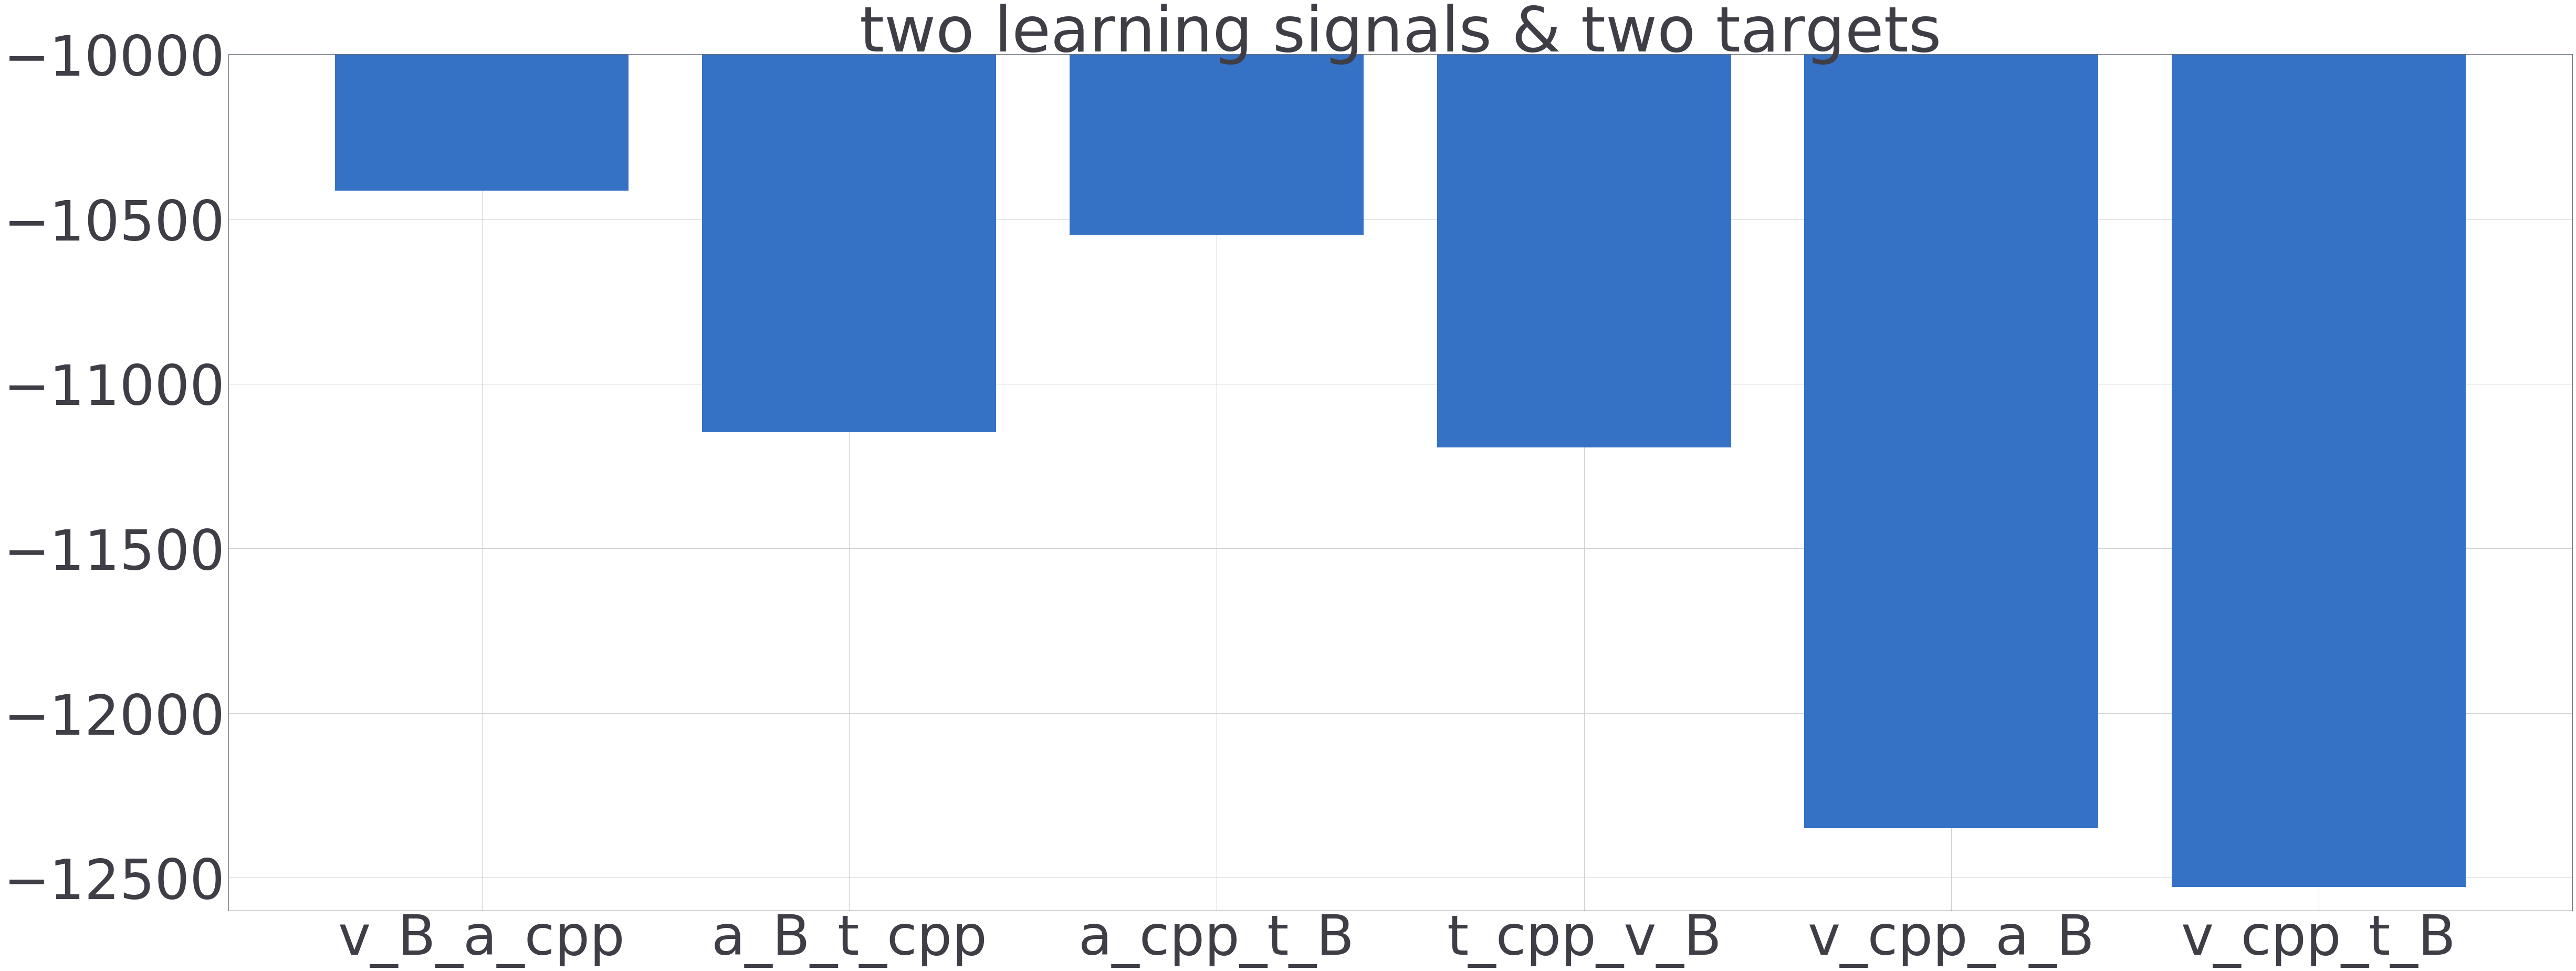

In [76]:
#compare dics 
ls_2_t_2_m_names = ['v_B_a_cpp', 'a_B_t_cpp', 'a_cpp_t_B', 't_cpp_v_B', 
                    'v_cpp_a_B',  'v_cpp_t_B']
ls_2_t_2_m_dics = [v_B_a_cpp_subj_obs_reg.dic, a_B_t_cpp_subj_obs_reg.dic,
            a_cpp_t_B_subj_obs_reg.dic,  t_cpp_v_B_subj_obs_reg.dic, 
                   v_cpp_a_B_subj_obs_reg.dic, v_cpp_t_B_subj_obs_reg.dic ]
plt.bar(ls_2_t_2_m_names,ls_2_t_2_m_dics)
plt.ylim([-12600,-10000])
plt.title('two learning signals & two targets')

In [89]:
v_B_a_cpp_subj_obs_reg.save(write_dir+'v_B_a_cpp_subj_obs_reg')
a_B_t_cpp_subj_obs_reg.save(write_dir+'a_B_t_cpp_subj_obs_reg')
a_cpp_t_B_subj_obs_reg.save(write_dir+'a_cpp_t_B_subj_obs_reg')
t_cpp_v_B_subj_obs_reg.save(write_dir+'t_cpp_v_B_subj_obs_reg')
v_cpp_a_B_subj_obs_reg.save(write_dir+'v_cpp_a_B_subj_obs_reg')
v_cpp_t_B_subj_obs_reg.save(write_dir+'v_cpp_t_B_subj_obs_reg')

   ## Two learning signals, three targets

In [66]:
#v_B & a_B & t_B -
#v_B & a_B & t_cpp -

#v_B & a_cpp & t_B-
#v_B & a_cpp & t_cpp -

#v_cpp & a_B & t_B-
#v_cpp & a_B & t_cpp-

#v_cpp & a_cpp & t_B -
#v_cpp & a_cpp & t_cpp-

In [67]:
v_a_t_B_subj_obs_reg = hddm.HDDMRegressor(data,[v+belief, a+belief, tr+belief],bias=True, include=include, informative=True)
v_a_t_B_subj_obs_reg.sample(n_samples,burn=n_burned_samples,dbname='v_a_t_B_subj_obs_reg.db', db='pickle')

Adding these covariates:
['v_Intercept', 'v_B:C(condition)[hc]', 'v_B:C(condition)[hv]', 'v_B:C(condition)[lc]', 'v_B:C(condition)[lv]']
Adding these covariates:
['a_Intercept', 'a_B:C(condition)[hc]', 'a_B:C(condition)[hv]', 'a_B:C(condition)[lc]', 'a_B:C(condition)[lv]']
Adding these covariates:
['t_Intercept', 't_B:C(condition)[hc]', 't_B:C(condition)[hv]', 't_B:C(condition)[lc]', 't_B:C(condition)[lv]']


/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 3001 of 3000 complete in 27770.5 sec

/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/ana

In [68]:
v_a_B_t_cpp_subj_obs_reg = hddm.HDDMRegressor(data,[v+belief, a+belief, tr+cpp],bias=True, include=include, informative=True)
v_a_B_t_cpp_subj_obs_reg.sample(n_samples,burn=n_burned_samples,dbname='v_a_B_t_cpp_subj_obs_reg.db', db='pickle')

Adding these covariates:
['v_Intercept', 'v_B:C(condition)[hc]', 'v_B:C(condition)[hv]', 'v_B:C(condition)[lc]', 'v_B:C(condition)[lv]']
Adding these covariates:
['a_Intercept', 'a_B:C(condition)[hc]', 'a_B:C(condition)[hv]', 'a_B:C(condition)[lc]', 'a_B:C(condition)[lv]']
Adding these covariates:
['t_Intercept', 't_cpp:C(condition)[hc]', 't_cpp:C(condition)[hv]', 't_cpp:C(condition)[lc]', 't_cpp:C(condition)[lv]']


/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 3001 of 3000 complete in 28158.2 sec

/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/ana

In [69]:
v_t_B_a_cpp_subj_obs_reg = hddm.HDDMRegressor(data,[v+belief, a+cpp, tr+belief],bias=True, include=include, informative=True)
v_t_B_a_cpp_subj_obs_reg.sample(n_samples,burn=n_burned_samples,dbname='v_t_B_a_cpp_subj_obs_reg.db', db='pickle')

Adding these covariates:
['v_Intercept', 'v_B:C(condition)[hc]', 'v_B:C(condition)[hv]', 'v_B:C(condition)[lc]', 'v_B:C(condition)[lv]']
Adding these covariates:
['a_Intercept', 'a_cpp:C(condition)[hc]', 'a_cpp:C(condition)[hv]', 'a_cpp:C(condition)[lc]', 'a_cpp:C(condition)[lv]']
Adding these covariates:
['t_Intercept', 't_B:C(condition)[hc]', 't_B:C(condition)[hv]', 't_B:C(condition)[lc]', 't_B:C(condition)[lv]']


/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 3001 of 3000 complete in 27340.5 sec

/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/ana

In [70]:
v_B_a_t_cpp_subj_obs_reg = hddm.HDDMRegressor(data,[v+belief, a+cpp, tr+cpp],bias=True, include=include, informative=True)
v_B_a_t_cpp_subj_obs_reg.sample(n_samples,burn=n_burned_samples,dbname='v_B_a_t_cpp_subj_obs_reg.db', db='pickle')

Adding these covariates:
['v_Intercept', 'v_B:C(condition)[hc]', 'v_B:C(condition)[hv]', 'v_B:C(condition)[lc]', 'v_B:C(condition)[lv]']
Adding these covariates:
['a_Intercept', 'a_cpp:C(condition)[hc]', 'a_cpp:C(condition)[hv]', 'a_cpp:C(condition)[lc]', 'a_cpp:C(condition)[lv]']
Adding these covariates:
['t_Intercept', 't_cpp:C(condition)[hc]', 't_cpp:C(condition)[hv]', 't_cpp:C(condition)[lc]', 't_cpp:C(condition)[lv]']


/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 3001 of 3000 complete in 27641.8 sec

/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/ana

In [71]:
v_cpp_a_t_B_subj_obs_reg = hddm.HDDMRegressor(data,[v+cpp, a+belief, tr+belief],bias=True, include=include, informative=True)
v_cpp_a_t_B_subj_obs_reg.sample(n_samples,burn=n_burned_samples,dbname='v_cpp_a_t_B_subj_obs_reg.db', db='pickle')

Adding these covariates:
['v_Intercept', 'v_cpp:C(condition)[hc]', 'v_cpp:C(condition)[hv]', 'v_cpp:C(condition)[lc]', 'v_cpp:C(condition)[lv]']
Adding these covariates:
['a_Intercept', 'a_B:C(condition)[hc]', 'a_B:C(condition)[hv]', 'a_B:C(condition)[lc]', 'a_B:C(condition)[lv]']
Adding these covariates:
['t_Intercept', 't_B:C(condition)[hc]', 't_B:C(condition)[hv]', 't_B:C(condition)[lc]', 't_B:C(condition)[lv]']


/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 3001 of 3000 complete in 33880.3 sec

/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/ana

In [72]:
a_t_B_v_cpp_subj_obs_reg = hddm.HDDMRegressor(data,[v+cpp, a+belief, tr+belief],bias=True, include=include, informative=True)
a_t_B_v_cpp_subj_obs_reg.sample(n_samples,burn=n_burned_samples,dbname='a_t_B_v_cpp_subj_obs_reg.db', db='pickle')

Adding these covariates:
['v_Intercept', 'v_cpp:C(condition)[hc]', 'v_cpp:C(condition)[hv]', 'v_cpp:C(condition)[lc]', 'v_cpp:C(condition)[lv]']
Adding these covariates:
['a_Intercept', 'a_B:C(condition)[hc]', 'a_B:C(condition)[hv]', 'a_B:C(condition)[lc]', 'a_B:C(condition)[lv]']
Adding these covariates:
['t_Intercept', 't_B:C(condition)[hc]', 't_B:C(condition)[hv]', 't_B:C(condition)[lc]', 't_B:C(condition)[lv]']


/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 3001 of 3000 complete in 33226.4 sec

/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/ana

In [73]:
v_t_cpp_a_B_subj_obs_reg = hddm.HDDMRegressor(data,[v+cpp, a+belief, tr+cpp],bias=True, include=include, informative=True)
v_t_cpp_a_B_subj_obs_reg.sample(n_samples,burn=n_burned_samples,dbname='v_t_cpp_a_B_subj_obs_reg.db', db='pickle')

Adding these covariates:
['v_Intercept', 'v_cpp:C(condition)[hc]', 'v_cpp:C(condition)[hv]', 'v_cpp:C(condition)[lc]', 'v_cpp:C(condition)[lv]']
Adding these covariates:
['a_Intercept', 'a_B:C(condition)[hc]', 'a_B:C(condition)[hv]', 'a_B:C(condition)[lc]', 'a_B:C(condition)[lv]']
Adding these covariates:
['t_Intercept', 't_cpp:C(condition)[hc]', 't_cpp:C(condition)[hv]', 't_cpp:C(condition)[lc]', 't_cpp:C(condition)[lv]']


/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 3001 of 3000 complete in 34818.6 sec

/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/ana

In [74]:
v_a_cpp_t_B_subj_obs_reg = hddm.HDDMRegressor(data,[v+cpp, a+cpp, tr+belief],bias=True, include=include, informative=True)
v_a_cpp_t_B_subj_obs_reg.sample(n_samples,burn=n_burned_samples,dbname='v_a_cpp_t_B_subj_obs_reg.db', db='pickle')

Adding these covariates:
['v_Intercept', 'v_cpp:C(condition)[hc]', 'v_cpp:C(condition)[hv]', 'v_cpp:C(condition)[lc]', 'v_cpp:C(condition)[lv]']
Adding these covariates:
['a_Intercept', 'a_cpp:C(condition)[hc]', 'a_cpp:C(condition)[hv]', 'a_cpp:C(condition)[lc]', 'a_cpp:C(condition)[lv]']
Adding these covariates:
['t_Intercept', 't_B:C(condition)[hc]', 't_B:C(condition)[hv]', 't_B:C(condition)[lc]', 't_B:C(condition)[lv]']


/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 3001 of 3000 complete in 32321.3 sec

/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/ana

In [75]:
v_a_t_cpp_subj_obs_reg = hddm.HDDMRegressor(data,[v+cpp, a+cpp, tr+cpp],bias=True, include=include, informative=True)
v_a_t_cpp_subj_obs_reg.sample(n_samples,burn=n_burned_samples,dbname='v_a_t_cpp_subj_obs_reg.db', db='pickle')

Adding these covariates:
['v_Intercept', 'v_cpp:C(condition)[hc]', 'v_cpp:C(condition)[hv]', 'v_cpp:C(condition)[lc]', 'v_cpp:C(condition)[lv]']
Adding these covariates:
['a_Intercept', 'a_cpp:C(condition)[hc]', 'a_cpp:C(condition)[hv]', 'a_cpp:C(condition)[lc]', 'a_cpp:C(condition)[lv]']
Adding these covariates:
['t_Intercept', 't_cpp:C(condition)[hc]', 't_cpp:C(condition)[hv]', 't_cpp:C(condition)[lc]', 't_cpp:C(condition)[lv]']


/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 3001 of 3000 complete in 33564.7 sec

/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/ana

Text(0.5,1,'two learning signals & three targets')

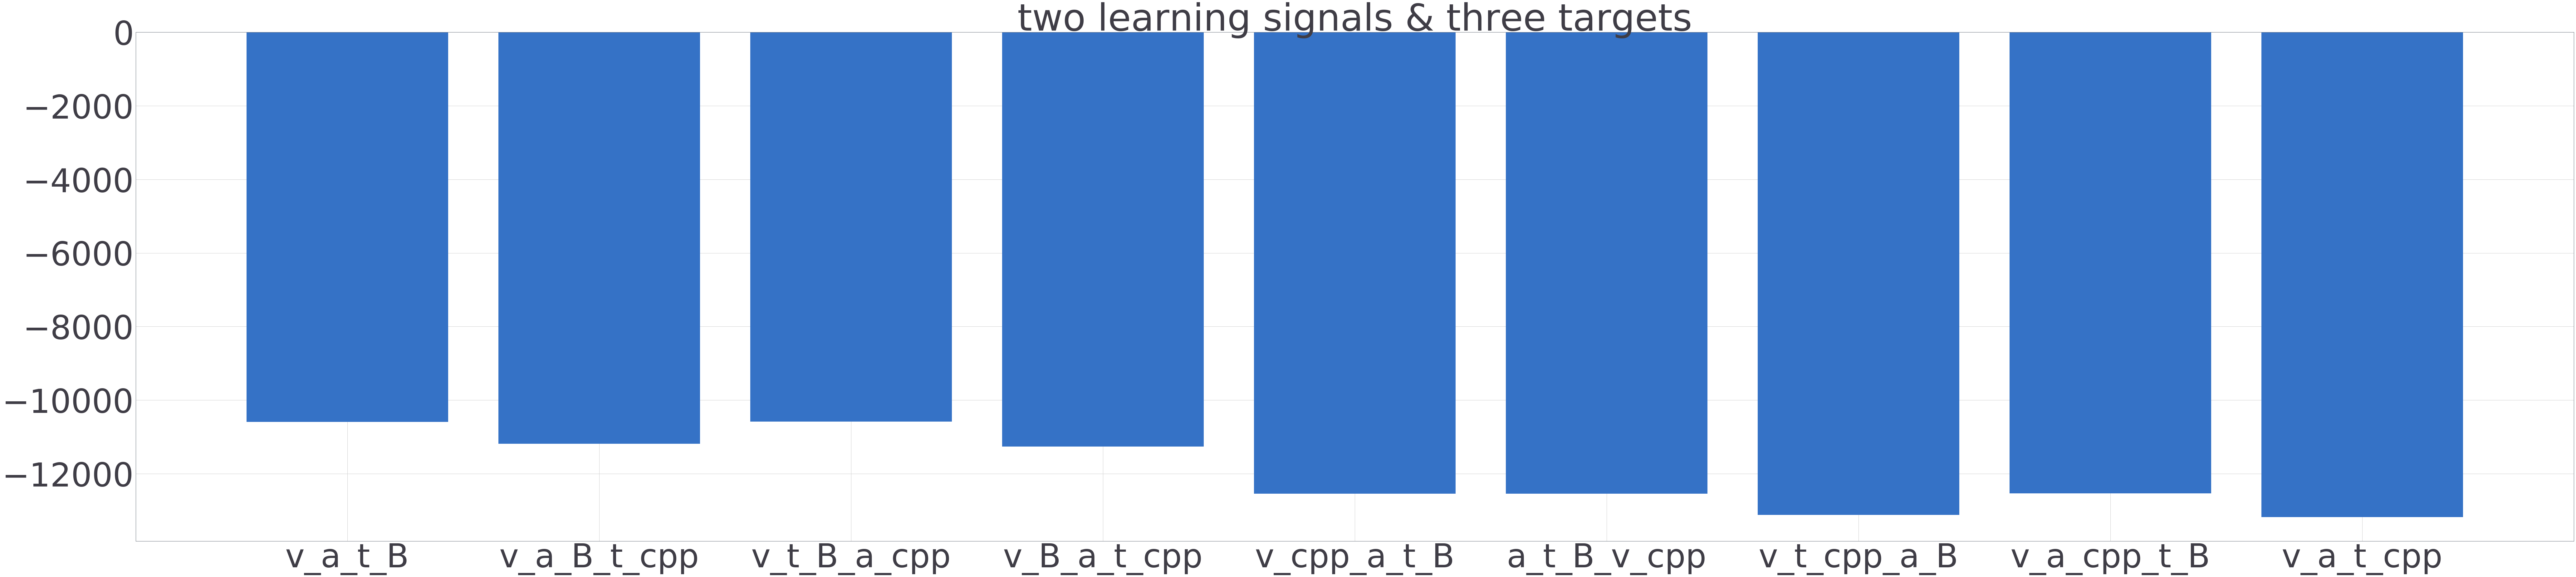

In [83]:
jtplot.style('grade3', context='paper', fscale=10)
plt.rcParams['figure.figsize'] = 140, 30

ls_2_t_3_m_names = ['v_a_t_B', 'v_a_B_t_cpp', 
                   'v_t_B_a_cpp', 'v_B_a_t_cpp',
                    'v_cpp_a_t_B', 'a_t_B_v_cpp',
                    'v_t_cpp_a_B', 'v_a_cpp_t_B',
                    'v_a_t_cpp']
ls_2_t_3_m_dics = [v_a_t_B_subj_obs_reg.dic, v_a_B_t_cpp_subj_obs_reg.dic, 
                  v_t_B_a_cpp_subj_obs_reg.dic, v_B_a_t_cpp_subj_obs_reg.dic, 
                  v_cpp_a_t_B_subj_obs_reg.dic, a_t_B_v_cpp_subj_obs_reg.dic, 
                  v_t_cpp_a_B_subj_obs_reg.dic, v_a_cpp_t_B_subj_obs_reg.dic,
                  v_a_t_cpp_subj_obs_reg.dic]
plt.bar(ls_2_t_3_m_names,ls_2_t_3_m_dics)
# plt.ylim([-12600,-10000])
plt.title('two learning signals & three targets')

In [90]:
v_a_t_B_subj_obs_reg.save(write_dir+'v_a_t_B_subj_obs_reg')
v_a_B_t_cpp_subj_obs_reg.save(write_dir+'v_a_B_t_cpp_subj_obs_reg')

v_t_B_a_cpp_subj_obs_reg.save(write_dir+'v_t_B_a_cpp_subj_obs_reg')
v_B_a_t_cpp_subj_obs_reg.save(write_dir+'v_B_a_t_cpp_subj_obs_reg')

v_cpp_a_t_B_subj_obs_reg.save(write_dir+'v_cpp_a_t_B_subj_obs_reg')
a_t_B_v_cpp_subj_obs_reg.save(write_dir+'a_t_B_v_cpp_subj_obs_reg')

v_t_cpp_a_B_subj_obs_reg.save(write_dir+'v_t_cpp_a_B_subj_obs_reg')
v_a_cpp_t_B_subj_obs_reg.save(write_dir+'v_a_cpp_t_B_subj_obs_reg')

v_a_t_cpp_subj_obs_reg.save(write_dir+'v_a_t_cpp_subj_obs_reg')

## Plotting all models together... 

In [ ]:
#combine all of the models into a single dataframe
#plot from lowest to highest 

#extract estimates of best model and find rts using these estimates (a la kyle)


In [ ]:
aRegressors = ['a_Intercept', "a_cpp:C(stim)[hc]", 
               "a_cpp:C(stim)[lc]", "a_cpp:C(stim)[hv]","a_cpp:C(stim)[lv]"]
vRegressors = ['v_Intercept', "v_B:C(stim)[hc]", "v_B:C(stim)[lc]",
               "v_B:C(stim)[hv]", "v_B:C(stim)[lv]"]
regressors = [aRegressors, vRegressors]
pdists = []; lvls = ['hc', 'lc', 'hv', 'lv']; params = ['a', 'v']
for param, paramRegs in zip(params, regressors):
    traces = av_within_subj_obs_reg.nodes_db.ix[paramRegs, 'node']
    c0 = traces[0].trace().mean()
    condTraces = traces[1:]
    pdist = pd.DataFrame({lvl:cTrace.trace() for (lvl, cTrace) in zip(lvls, condTraces)})
    pdistTidy = pd.melt(pdist, var_name='level')
    pdistTidy['param'] = param
    pdists.append(pdistTidy)
pdists = pd.concat(pdists)
vdists = pdists[pdists.param=='v']
adists = pdists[pdists.param=='a']

In [ ]:
av_within_subj_obs_reg.print_stats()

In [ ]:
t = av_within_subj_obs_reg.nodes_db.ix[['t'], 'mean'][0]
# z = av_within_subj_obs_reg.nodes_db.ix[['z'], 'mean'][0]

v0 = av_within_subj_obs_reg.nodes_db.ix[['v_Intercept'], 'mean'][0]
v_beta_hc = av_within_subj_obs_reg.nodes_db.ix[['v_B:C(stim)[hc]'], 'mean'][0]
v_beta_lc = av_within_subj_obs_reg.nodes_db.ix[['v_B:C(stim)[lc]'], 'mean'][0]
v_beta_hv = av_within_subj_obs_reg.nodes_db.ix[['v_B:C(stim)[hv]'], 'mean'][0]
v_beta_lv = av_within_subj_obs_reg.nodes_db.ix[['v_B:C(stim)[lv]'], 'mean'][0]


In [ ]:
a0 = av_within_subj_obs_reg.nodes_db.ix[['a_Intercept'], 'mean'][0]
a_beta_hc = av_within_subj_obs_reg.nodes_db.ix[['a_cpp:C(stim)[hc]'], 'mean'][0]
a_beta_lc = av_within_subj_obs_reg.nodes_db.ix[['a_cpp:C(stim)[lc]'], 'mean'][0]
a_beta_hv = av_within_subj_obs_reg.nodes_db.ix[['a_cpp:C(stim)[hv]'], 'mean'][0]
a_beta_lv = av_within_subj_obs_reg.nodes_db.ix[['a_cpp:C(stim)[lv]'], 'mean'][0]

In [ ]:
print(a0,a_beta_hc, a_beta_lc)

In [ ]:
plt.plot(v_hc_trials); plt.show()


In [ ]:
v_hc_trials = v0 + v_beta_hc * data[data.stim=='hc']['B'] 
v_lc_trials = v0 + v_beta_lc * data[data.stim=='lc']['B'] 
v_hv_trials = v0 + v_beta_hc * data[data.stim=='hv']['B'] 
v_lv_trials = v0 + v_beta_lc * data[data.stim=='lv']['B'] 


plt.plot(v_hc_trials[:50].values, label='hc')
plt.plot(v_lc_trials[:50].values, label='lc')
plt.plot(v_hv_trials[:50].values, label='hv')
plt.plot(v_lv_trials[:50].values, label='lv')

ax = plt.gca()
ax.set_ylabel('Drift-Rate')
ax.set_xlabel('Trials')
ax.legend()

In [ ]:
v_hc_trials

In [ ]:
a_hc_trials = a0 + a_beta_hc * data[data.stim=='hc']['cpp'] 
a_lc_trials = a0 + a_beta_lc * data[data.stim=='lc']['cpp'] 
a_hv_trials = a0 + a_beta_hc * data[data.stim=='hv']['cpp'] 
a_lv_trials = a0 + a_beta_lc * data[data.stim=='lv']['cpp'] 


plt.plot(a_hc_trials[:50].values, label='hc')
plt.plot(a_lc_trials[:50].values, label='lc')
plt.plot(a_hv_trials[:50].values, label='hv')
plt.plot(a_lv_trials[:50].values, label='lv')

ax = plt.gca()
ax.set_ylabel('Threshold')
ax.set_xlabel('Trials')
ax.legend()

In [ ]:
import seaborn as sns
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15))
                             
sns.violinplot(x='level', y='value', data=vdists, palette='viridis', order=lvls, ax=ax1, linewidth=0)
sns.violinplot(x='level', y='value', data=adists, palette='viridis', order=lvls, ax=ax2, linewidth=0)
ax1.set_ylabel('Posterior Density')
ax2.set_ylabel('')
ax1.set_title('Drift-Rate ($v$)')
ax2.set_title('Boundary Height ($a$)')

plt.tight_layout()
sns.despine()

#### save models

In [ ]:
av_within_subj_obs_reg.save(write_dir+'av_within_subj_observed_cleaned_reg')
a_within_subj_obs_reg.save(write_dir+'a_within_subj_observed_cleaned_reg')
v_within_subj_obs_reg.save(write_dir+'v_within_subj_observed_cleaned_reg')

#### extract DIC score

In [ ]:
v_within_subj_obs_reg.dic, a_within_subj_obs_reg.dic, av_within_subj_obs_reg.dic

In [ ]:
v_within_subj_obs_reg.dic

#### plot within-subjects effects for winning model

In [ ]:
plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['axes.titlesize'] = 25
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

# names = [r'$a+v$',r'$v$',r'$a$']
# colors = ['red', 'green', 'blue']
names = ['combined', 'drift rate', 'decision threshold']
dics = [av_within_subj_obs_reg.dic, v_within_subj_obs_reg.dic, a_within_subj_obs_reg.dic]
bars=plt.barh(names, dics, color='forestgreen')
plt.xlim([-7825,-7700])

plt.xlabel('DIC score')
bars[0].set_alpha(1)
bars[1].set_alpha(.8)
bars[2].set_alpha(.5)
plt.axvline(av_within_subj_obs_reg.dic, color='k', alpha=0.5, linestyle = '--')
# plt.savefig(write_dir+'observed_dics.pdf')

In [ ]:
v_hc, v_hv, v_lc, v_lv = av_within_subj_obs.nodes_db.ix[['v_C(stim)[hc]', 'v_C(stim)[hv]', 'v_C(stim)[lc]', 'v_C(stim)[lv]'], 'node']


drift_fig=hddm.analyze.plot_posterior_nodes([v_hc, v_hv, v_lc, v_lv])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('All groups: Group mean posteriors of within-subject drift-rate effects.')
# plt.savefig('hddm_demo_fig_07.pdf')

In [ ]:
drift_fig=hddm.analyze.plot_posterior_nodes([v_hc, v_lc])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.legend()
plt.title('All groups: Group mean posteriors of within-subject drift-rate effects.')
# plt.savefig('hddm_demo_fig_07.pdf')

In [ ]:
a_hc, a_hv, a_lc, a_lv  = av_within_subj_obs.nodes_db.ix[['a_C(stim)[hc]', 'a_C(stim)[hv]', 'a_C(stim)[lc]', 'a_C(stim)[lv]'], 'node']
bound_fig = hddm.analyze.plot_posterior_nodes([a_hc, a_hv, a_lc, a_lv])
plt.legend()
plt.xlabel('bound')
plt.ylabel('Posteriore probability')
plt.title('All Groups: Group mean posteriors of within-subject bound effects.')
# plt.savefig('hddm_demo_fig_07.pdf')

#### Hypothesized contrasts

In [ ]:
a_hc, a_hv, a_lc, a_lv  = av_within_subj_obs.nodes_db.ix[['a_C(stim)[hc]', 'a_C(stim)[hv]', 'a_C(stim)[lc]', 'a_C(stim)[lv]'], 'node']
hddm.analyze.plot_posterior_nodes([a_lv, a_hv])
plt.xlabel('bound')
plt.ylabel('Posterior probability')
plt.title('Volatility: Group mean posteriors of within-subject bound effects.')

In [ ]:
v_hc, v_hv, v_lc, v_lv = av_within_subj_obs.nodes_db.ix[['v_C(stim)[hc]', 'v_C(stim)[hv]', 'v_C(stim)[lc]', 'v_C(stim)[lv]'], 'node']
hddm.analyze.plot_posterior_nodes([v_hc, v_lc])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Conflict: Group mean posteriors of within-subject drift-rate effects.')
# plt.savefig('hddm_demo_fig_07.pdf')

#### all stats

In [ ]:
# v_within_subj.print_stats()

In [ ]:
av_within_subj_obs.plot_posterior_predictive(figsize=(14, 10))

In [ ]:
# tst hyp. that bound ^ with vol
print("P(HV < LV) = ", (a_hv.trace() < a_lv.trace()).mean())
print("P(HC > LC) = ", (v_hc.trace() > v_lc.trace()).mean())

In [ ]:
print("P(LV < LC) = ", (a_lv.trace() < a_lc.trace()).mean())
print("P(LV < HC) = ", (a_lv.trace() < a_hc.trace()).mean())
print("P(LV < HV) = ", (a_lv.trace() < a_hv.trace()).mean())

In [ ]:
# tst hyp. that drift dec. with conf
print("P(HC > LC) = ", (v_hc.trace() > v_lc.trace()).mean())
print("P(HC > LV) = ", (v_hc.trace() > v_lv.trace()).mean())
print("P(HC > HV) = ", (v_hc.trace() > v_hv.trace()).mean())
